<a href="https://colab.research.google.com/github/lee-saint/Pixir/blob/master/SimpleGAN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
sys.path.append('drive/My Drive/Colab Notebooks/pixir/test')

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

from data import load_data, text_preprocessing
from models import build_bert_encoder, build_generator, build_discriminator
from train import train

TensorFlow 2.x selected.


In [0]:
BATCH_SIZE = 128
NUM_EPOCHS = 1700

In [0]:
%%time
images, texts = load_data(64, 64, 1)
print(images.shape)
print(texts.shape)

In [0]:
import numpy as np
import pandas as pd

images = np.load(open('drive/My Drive/Colab Notebooks/pixir/images3.npy', mode='rb'))
texts = pd.read_csv('drive/My Drive/Colab Notebooks/pixir/texts.csv', header=None)[1]

print(images.shape)
print(texts.shape)
texts.head()

(11788, 64, 64, 3)
(11788,)


0    light tan colored bird with a white head and a...
1    the wings are brown, long and narrow, and have...
2    the bird has head and beak proportional to its...
3    the bird has two large wingbars that are grey ...
4    this flying bird has long brown wings and a bl...
Name: 1, dtype: object

(-0.5, 63.5, 63.5, -0.5)

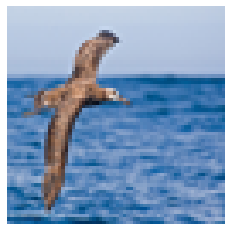

In [0]:
import matplotlib.pyplot as plt

plt.imshow(images[5])
plt.axis('off')

In [0]:
texts[5]

'a gull with rich brown feathers flies over the sea.'

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 4.6MB/s 


In [0]:
tokens, masks, segments = text_preprocessing(texts)
print(tokens.shape)
print(masks.shape)
print(segments.shape)

(11788, 32)
(11788, 32)
(11788, 32)


In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len, ), dtype=tf.int32, name='input_word_ids')
    input_mask = Input(shape=(max_len, ), dtype=tf.int32, name='input_mask')
    segment_ids = Input(shape=(max_len, ), dtype=tf.int32, name='segment_ids')
    
    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    # out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=clf_output)
    
    return model

In [0]:
%%time
from tensorflow.keras import Model
import tensorflow_hub as hub

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=False)

CPU times: user 9.7 s, sys: 1.14 s, total: 10.8 s
Wall time: 10.8 s


In [0]:
from tensorflow.keras.layers import Dense, Input

bert_model = build_model(bert_layer, max_len=32)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 32)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 32)]         0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [0]:
bert_model.save('drive/My Drive/Colab Notebooks/pixir/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/pixir/assets


INFO:tensorflow:Assets written to: drive/My Drive/Colab Notebooks/pixir/assets


In [0]:
%%time
text_vectors = bert_model.predict([tokens, masks, segments])
text_vectors.shape

CPU times: user 48.9 s, sys: 32.9 s, total: 1min 21s
Wall time: 1min 23s


In [0]:
text_vectors[0]

array([ 0.32845074, -0.9846333 ,  0.44069487, ..., -0.34888664,
       -0.23903087,  0.35869092], dtype=float32)

In [0]:
np.save('drive/My Drive/Colab Notebooks/pixir/text_vectors.npy', text_vectors)

In [0]:
text_vectors = np.load('drive/My Drive/Colab Notebooks/pixir/text_vectors.npy')
text_vectors.shape

(11788, 1024)

In [0]:
generator = build_generator((1124, ))
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              2301952   
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 2048)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 64)          73728     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

In [0]:
discriminator = build_discriminator((64, 64, 3), (1024, ))
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 64)   3072        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 32, 32, 64)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 128)  131072      leaky_re_lu_5[0][0]              
____________________________________________________________________________________________

In [0]:
generator = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/pixir/generator.h5')
discriminator = tf.keras.models.load_model('drive/My Drive/Colab Notebooks/pixir/discriminator.h5')

In [0]:
seeds = text_vectors[:16]

In [0]:
images_normalized = images.astype('float32') / 127.5 - 1
images_normalized.shape

(11788, 64, 64, 3)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((images_normalized, text_vectors))
dataset = dataset.shuffle(buffer_size=11788)
dataset = dataset.batch(BATCH_SIZE)

In [0]:
from tensorflow.keras.optimizers import Adam
g_optimizer = Adam(2e-5)
d_optimizer = Adam(2e-5)

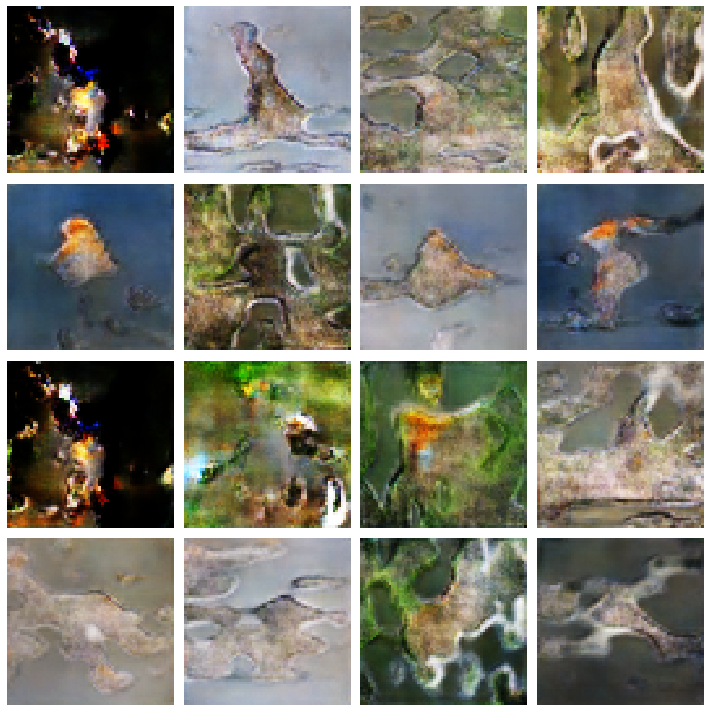

Time for epoch 1 is 18.381815671920776 sec
Time for epoch 2 is 17.909067153930664 sec
Time for epoch 3 is 18.20772957801819 sec
Time for epoch 4 is 18.587307691574097 sec
Time for epoch 5 is 18.900390148162842 sec
Time for epoch 6 is 18.631642818450928 sec
Time for epoch 7 is 18.464157581329346 sec
Time for epoch 8 is 18.54569935798645 sec
Time for epoch 9 is 18.57537579536438 sec
Time for epoch 10 is 18.60626220703125 sec
Time for epoch 11 is 18.655749082565308 sec
Time for epoch 12 is 18.6488676071167 sec
Time for epoch 13 is 18.61155939102173 sec
Time for epoch 14 is 18.677823781967163 sec


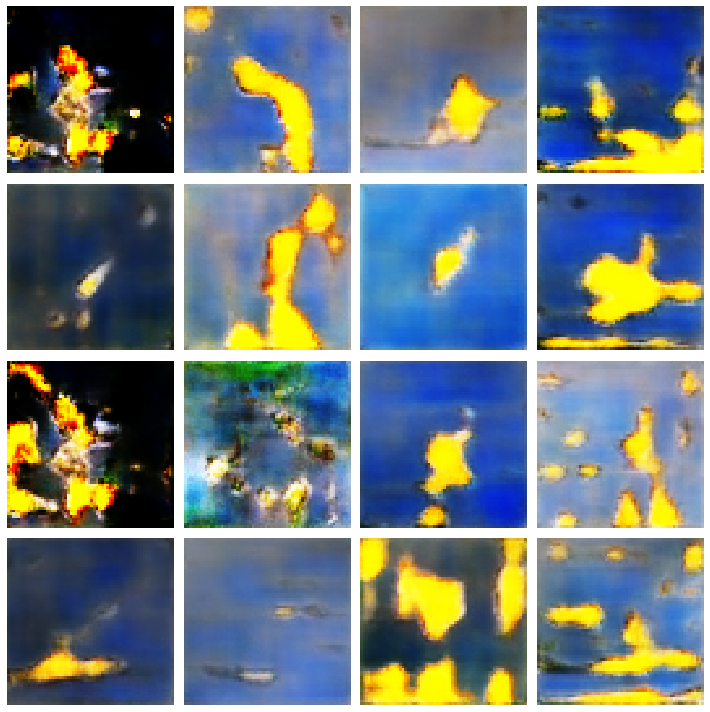

Time for epoch 15 is 19.38222050666809 sec
Time for epoch 16 is 18.63236355781555 sec
Time for epoch 17 is 18.614556074142456 sec
Time for epoch 18 is 18.61265802383423 sec
Time for epoch 19 is 18.64421272277832 sec
Time for epoch 20 is 18.62713861465454 sec
Time for epoch 21 is 18.64135217666626 sec
Time for epoch 22 is 18.693636655807495 sec
Time for epoch 23 is 18.59744930267334 sec
Time for epoch 24 is 18.572590351104736 sec
Time for epoch 25 is 18.5803644657135 sec
Time for epoch 26 is 18.61391520500183 sec
Time for epoch 27 is 18.618916273117065 sec
Time for epoch 28 is 18.62819480895996 sec
Time for epoch 29 is 18.617140769958496 sec


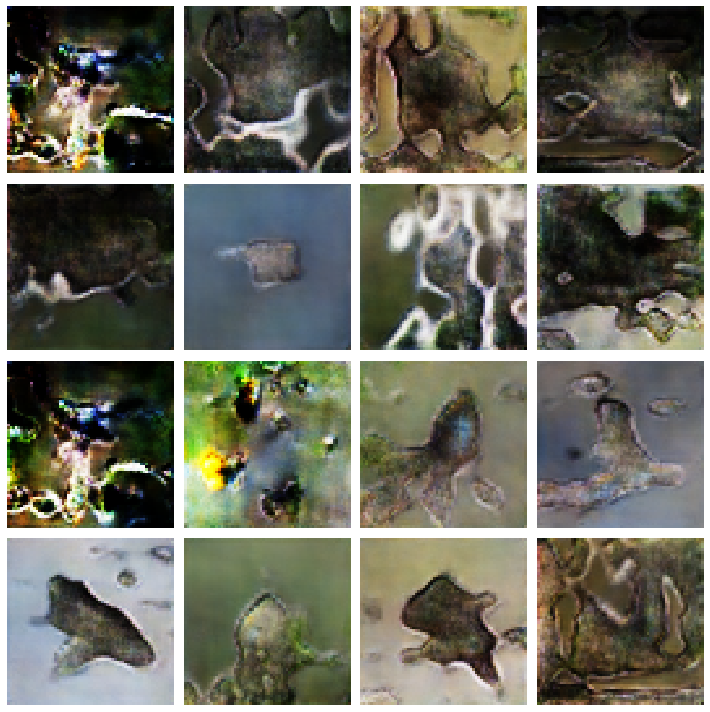

Time for epoch 30 is 19.49259328842163 sec
Time for epoch 31 is 18.6219220161438 sec
Time for epoch 32 is 18.642797470092773 sec
Time for epoch 33 is 18.631563663482666 sec
Time for epoch 34 is 18.628297567367554 sec
Time for epoch 35 is 18.629496335983276 sec
Time for epoch 36 is 18.62038230895996 sec
Time for epoch 37 is 18.647990465164185 sec
Time for epoch 38 is 18.610179901123047 sec
Time for epoch 39 is 18.594138860702515 sec
Time for epoch 40 is 18.672541856765747 sec
Time for epoch 41 is 18.649214506149292 sec
Time for epoch 42 is 18.567858695983887 sec
Time for epoch 43 is 18.50911283493042 sec
Time for epoch 44 is 18.595618963241577 sec


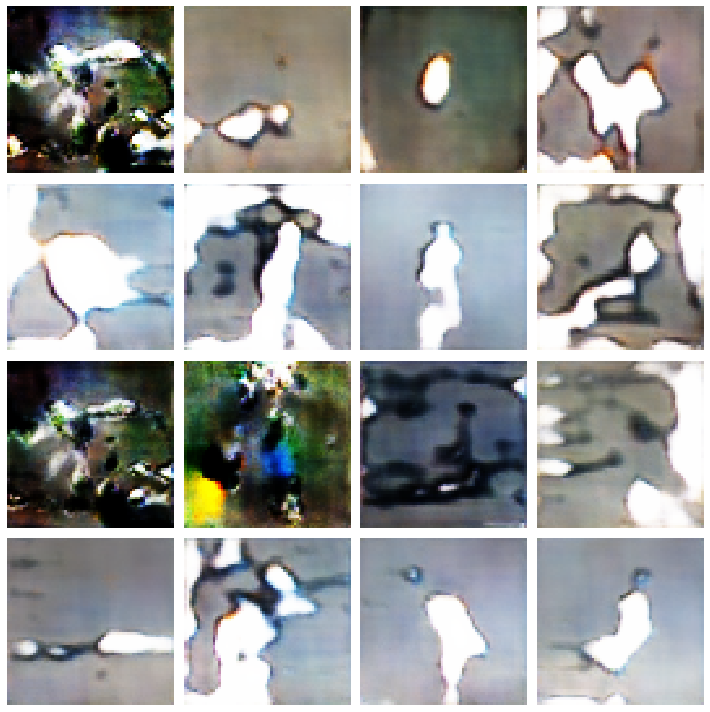

Time for epoch 45 is 19.34136128425598 sec
Time for epoch 46 is 18.765822887420654 sec
Time for epoch 47 is 18.550503969192505 sec
Time for epoch 48 is 18.520421266555786 sec
Time for epoch 49 is 18.61172080039978 sec
Time for epoch 50 is 18.6889705657959 sec
Time for epoch 51 is 18.59840154647827 sec
Time for epoch 52 is 18.532915115356445 sec
Time for epoch 53 is 18.552811861038208 sec
Time for epoch 54 is 18.605924606323242 sec
Time for epoch 55 is 18.657902479171753 sec
Time for epoch 56 is 18.616658449172974 sec
Time for epoch 57 is 18.58469581604004 sec
Time for epoch 58 is 18.600055932998657 sec
Time for epoch 59 is 18.587424516677856 sec


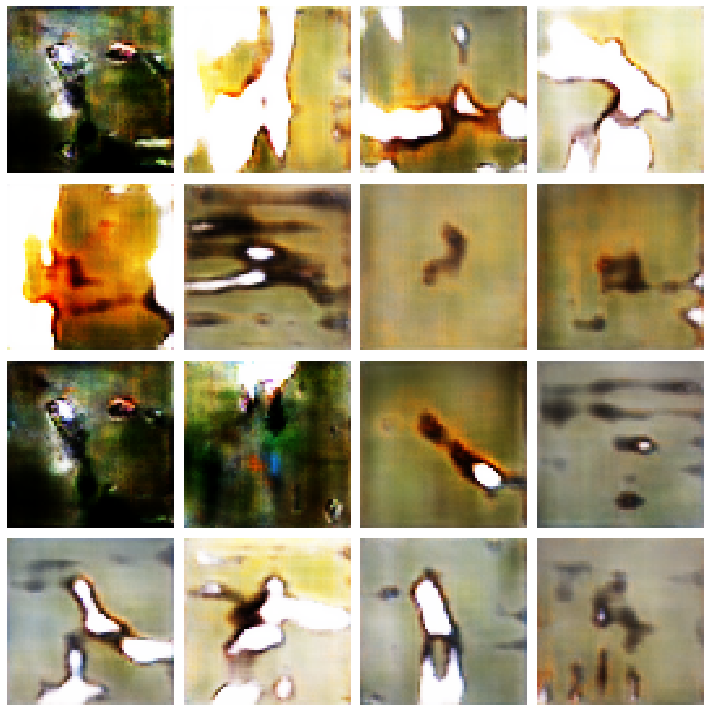

Time for epoch 60 is 19.415152549743652 sec
Time for epoch 61 is 18.645695209503174 sec
Time for epoch 62 is 18.642871856689453 sec
Time for epoch 63 is 18.643252849578857 sec
Time for epoch 64 is 18.666725158691406 sec
Time for epoch 65 is 18.669132709503174 sec
Time for epoch 66 is 18.64755153656006 sec
Time for epoch 67 is 18.671184062957764 sec
Time for epoch 68 is 18.59567928314209 sec
Time for epoch 69 is 18.58850073814392 sec
Time for epoch 70 is 18.64470386505127 sec
Time for epoch 71 is 18.595556259155273 sec
Time for epoch 72 is 18.548973560333252 sec
Time for epoch 73 is 18.66533350944519 sec
Time for epoch 74 is 18.629693269729614 sec


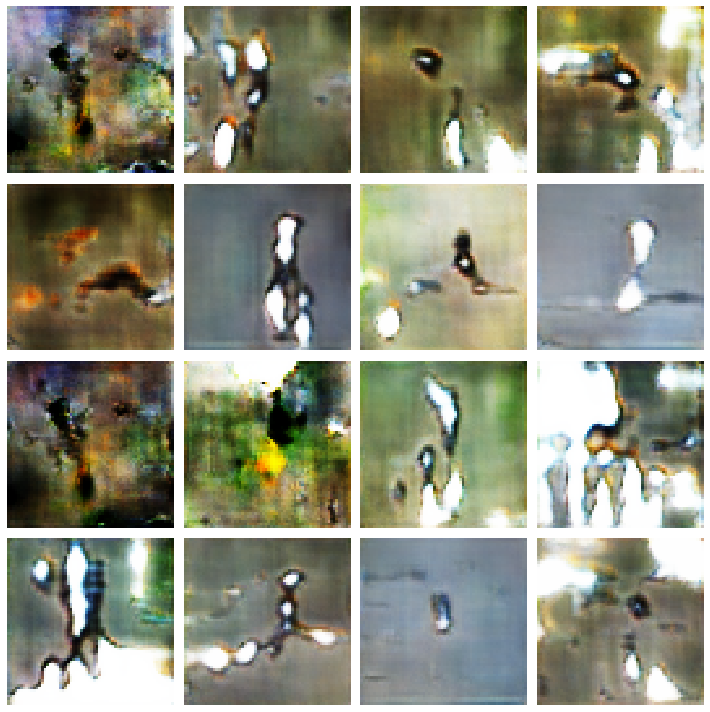

Time for epoch 75 is 19.350779056549072 sec
Time for epoch 76 is 18.654126405715942 sec
Time for epoch 77 is 18.58725118637085 sec
Time for epoch 78 is 18.58185362815857 sec
Time for epoch 79 is 18.627176523208618 sec
Time for epoch 80 is 18.59037685394287 sec
Time for epoch 81 is 18.598615407943726 sec
Time for epoch 82 is 18.60741376876831 sec
Time for epoch 83 is 18.62100100517273 sec
Time for epoch 84 is 18.61576223373413 sec
Time for epoch 85 is 18.601016521453857 sec
Time for epoch 86 is 18.59592843055725 sec
Time for epoch 87 is 18.62143325805664 sec
Time for epoch 88 is 18.601145029067993 sec
Time for epoch 89 is 18.608231782913208 sec


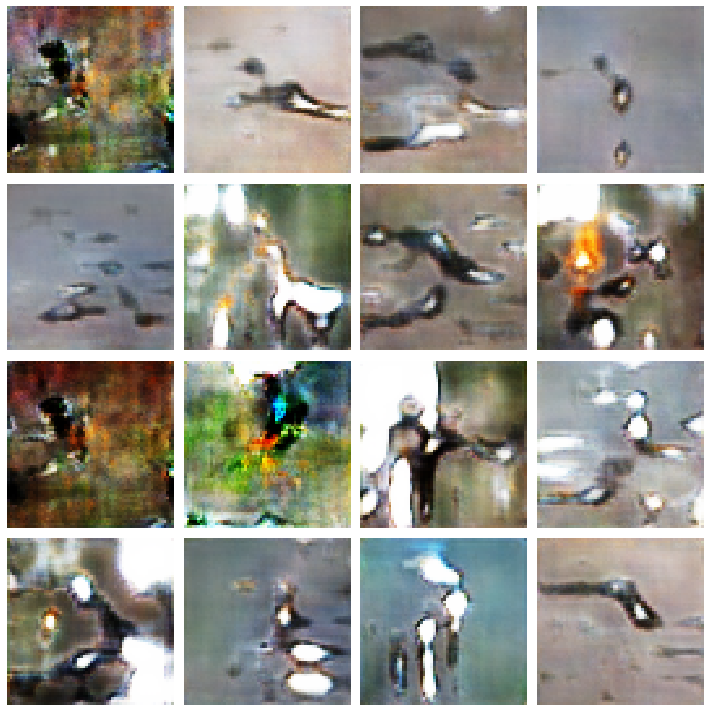

Time for epoch 90 is 19.353341579437256 sec
Time for epoch 91 is 18.709215879440308 sec
Time for epoch 92 is 18.615376472473145 sec
Time for epoch 93 is 18.62108612060547 sec
Time for epoch 94 is 18.647763967514038 sec
Time for epoch 95 is 18.53516721725464 sec
Time for epoch 96 is 18.554604291915894 sec
Time for epoch 97 is 18.629618883132935 sec
Time for epoch 98 is 18.633143663406372 sec
Time for epoch 99 is 18.61689805984497 sec
Time for epoch 100 is 18.59662365913391 sec
Time for epoch 101 is 18.588887453079224 sec
Time for epoch 102 is 18.560638189315796 sec
Time for epoch 103 is 18.56920027732849 sec
Time for epoch 104 is 18.577861547470093 sec


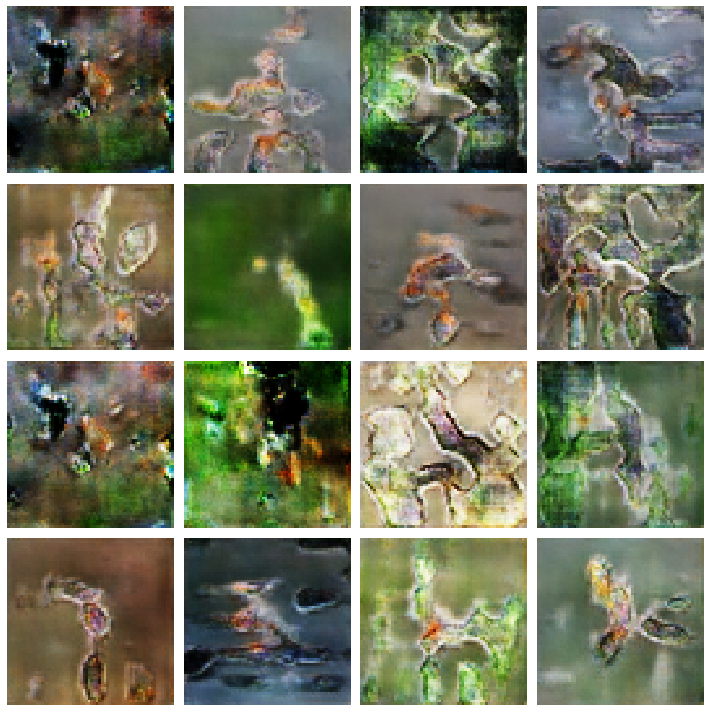

Time for epoch 105 is 19.318198442459106 sec
Time for epoch 106 is 18.615808248519897 sec
Time for epoch 107 is 18.59451389312744 sec
Time for epoch 108 is 18.60259699821472 sec
Time for epoch 109 is 18.636934757232666 sec
Time for epoch 110 is 18.616308450698853 sec
Time for epoch 111 is 18.669963121414185 sec
Time for epoch 112 is 18.579569816589355 sec
Time for epoch 113 is 18.57797622680664 sec
Time for epoch 114 is 18.534464359283447 sec
Time for epoch 115 is 18.559863567352295 sec
Time for epoch 116 is 18.5355703830719 sec
Time for epoch 117 is 18.55929970741272 sec
Time for epoch 118 is 18.57839584350586 sec
Time for epoch 119 is 18.632468223571777 sec


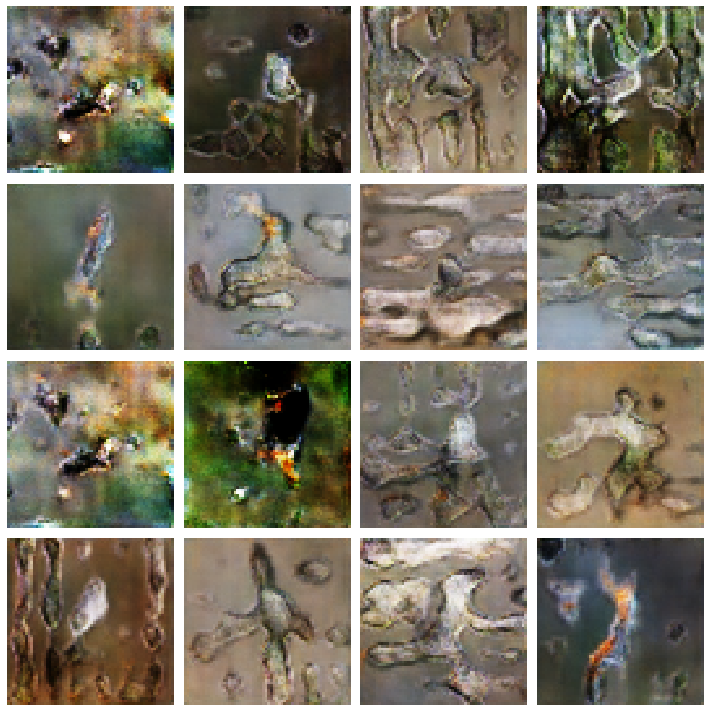

Time for epoch 120 is 19.40872073173523 sec
Time for epoch 121 is 18.62156391143799 sec
Time for epoch 122 is 18.590358018875122 sec
Time for epoch 123 is 18.574466943740845 sec
Time for epoch 124 is 18.617598056793213 sec
Time for epoch 125 is 18.62132716178894 sec
Time for epoch 126 is 18.62729787826538 sec
Time for epoch 127 is 18.58021092414856 sec
Time for epoch 128 is 18.57545781135559 sec
Time for epoch 129 is 18.601755380630493 sec
Time for epoch 130 is 18.622215270996094 sec
Time for epoch 131 is 18.55056357383728 sec
Time for epoch 132 is 18.612660884857178 sec
Time for epoch 133 is 18.61550807952881 sec
Time for epoch 134 is 18.60513138771057 sec


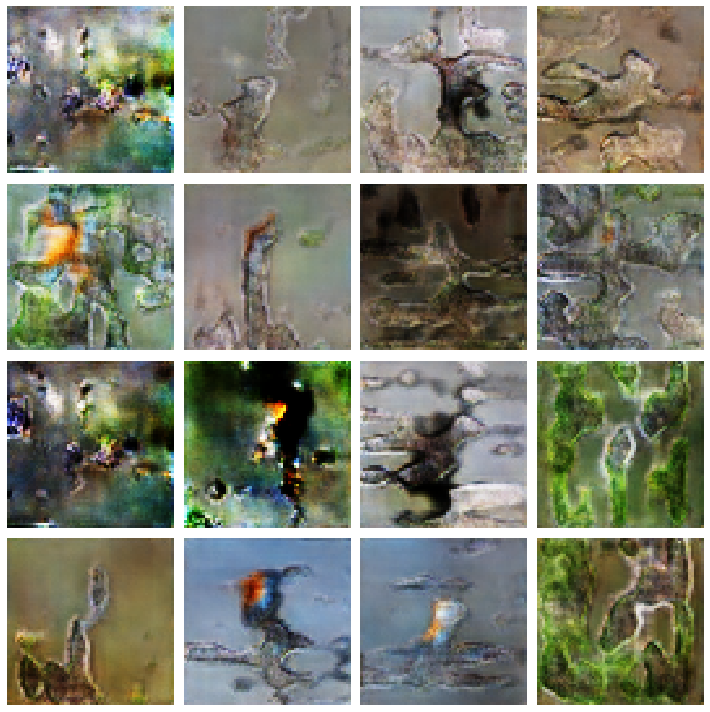

Time for epoch 135 is 19.549768924713135 sec
Time for epoch 136 is 18.626386165618896 sec
Time for epoch 137 is 18.657644510269165 sec
Time for epoch 138 is 18.67103409767151 sec
Time for epoch 139 is 18.614588499069214 sec
Time for epoch 140 is 18.597818613052368 sec
Time for epoch 141 is 18.61005735397339 sec
Time for epoch 142 is 18.648196935653687 sec
Time for epoch 143 is 18.642358541488647 sec
Time for epoch 144 is 18.55333971977234 sec
Time for epoch 145 is 18.582534074783325 sec
Time for epoch 146 is 18.62400984764099 sec
Time for epoch 147 is 18.715041160583496 sec
Time for epoch 148 is 18.6743221282959 sec
Time for epoch 149 is 18.604410886764526 sec


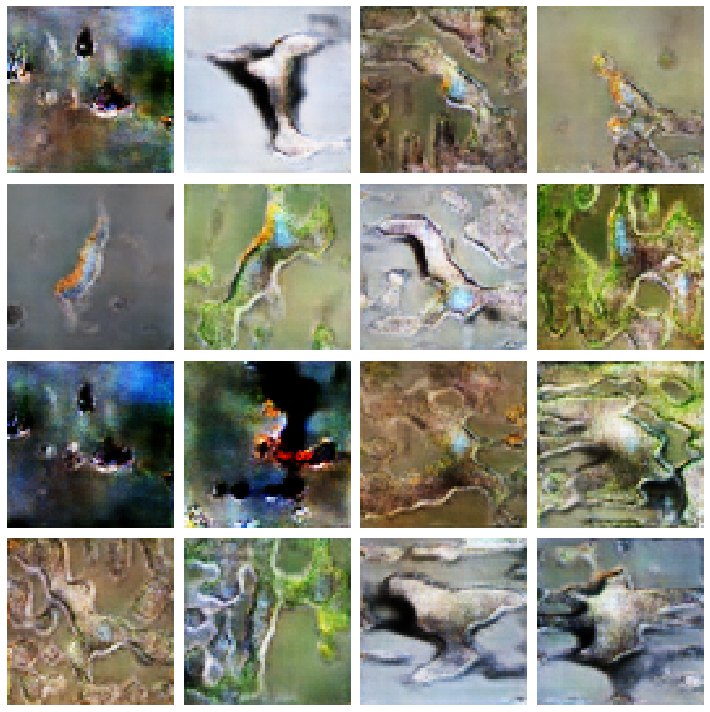

Time for epoch 150 is 19.35346484184265 sec
Time for epoch 151 is 18.601963758468628 sec
Time for epoch 152 is 18.626212120056152 sec
Time for epoch 153 is 18.591965913772583 sec
Time for epoch 154 is 18.583741664886475 sec
Time for epoch 155 is 18.55395817756653 sec
Time for epoch 156 is 18.565112829208374 sec
Time for epoch 157 is 18.642096281051636 sec
Time for epoch 158 is 18.586766481399536 sec
Time for epoch 159 is 18.653762340545654 sec
Time for epoch 160 is 18.60104274749756 sec
Time for epoch 161 is 18.60810422897339 sec
Time for epoch 162 is 18.579749584197998 sec
Time for epoch 163 is 18.563628435134888 sec
Time for epoch 164 is 18.52958631515503 sec


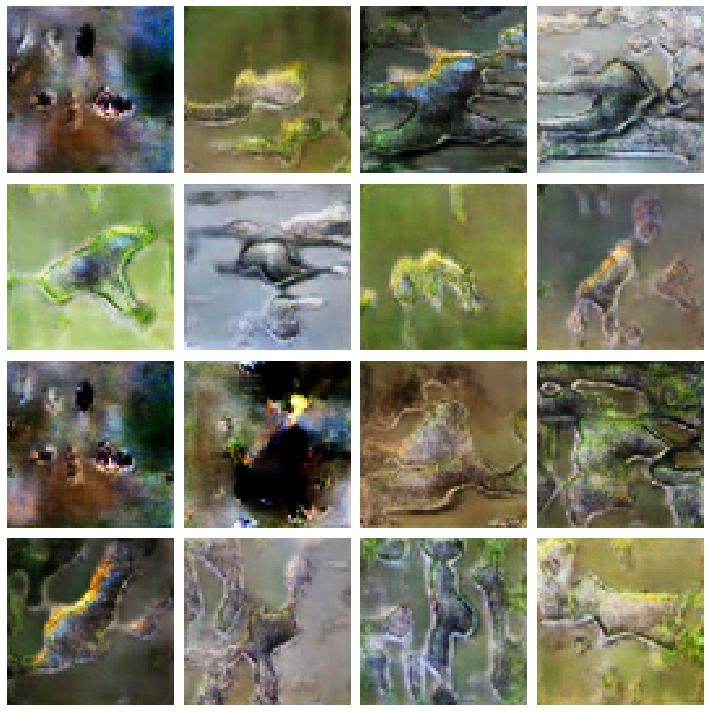

Time for epoch 165 is 19.338218927383423 sec
Time for epoch 166 is 18.55704665184021 sec
Time for epoch 167 is 18.571088314056396 sec
Time for epoch 168 is 18.653403282165527 sec
Time for epoch 169 is 18.66682767868042 sec
Time for epoch 170 is 18.629202842712402 sec
Time for epoch 171 is 18.61305046081543 sec
Time for epoch 172 is 18.547359704971313 sec
Time for epoch 173 is 18.591100692749023 sec
Time for epoch 174 is 18.672451734542847 sec
Time for epoch 175 is 18.672151803970337 sec
Time for epoch 176 is 18.641727447509766 sec
Time for epoch 177 is 18.645567893981934 sec
Time for epoch 178 is 18.60320281982422 sec
Time for epoch 179 is 18.612801551818848 sec


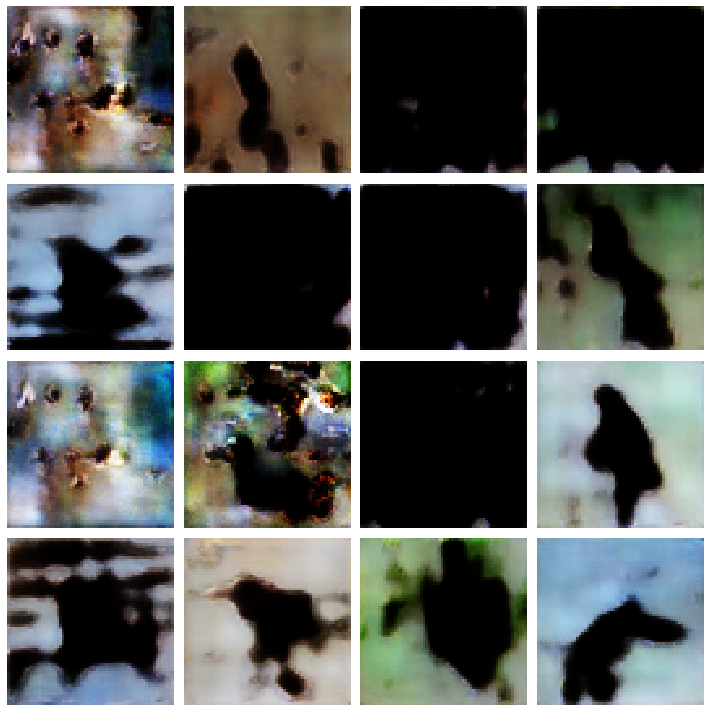

Time for epoch 180 is 19.298351526260376 sec
Time for epoch 181 is 18.595744848251343 sec
Time for epoch 182 is 18.607177019119263 sec
Time for epoch 183 is 18.624789237976074 sec
Time for epoch 184 is 18.609965085983276 sec
Time for epoch 185 is 18.577831029891968 sec
Time for epoch 186 is 18.557151317596436 sec
Time for epoch 187 is 18.576257944107056 sec
Time for epoch 188 is 18.57327437400818 sec
Time for epoch 189 is 18.6289541721344 sec
Time for epoch 190 is 18.601495504379272 sec
Time for epoch 191 is 18.691569089889526 sec
Time for epoch 192 is 18.51761245727539 sec
Time for epoch 193 is 18.513861179351807 sec
Time for epoch 194 is 18.56739115715027 sec


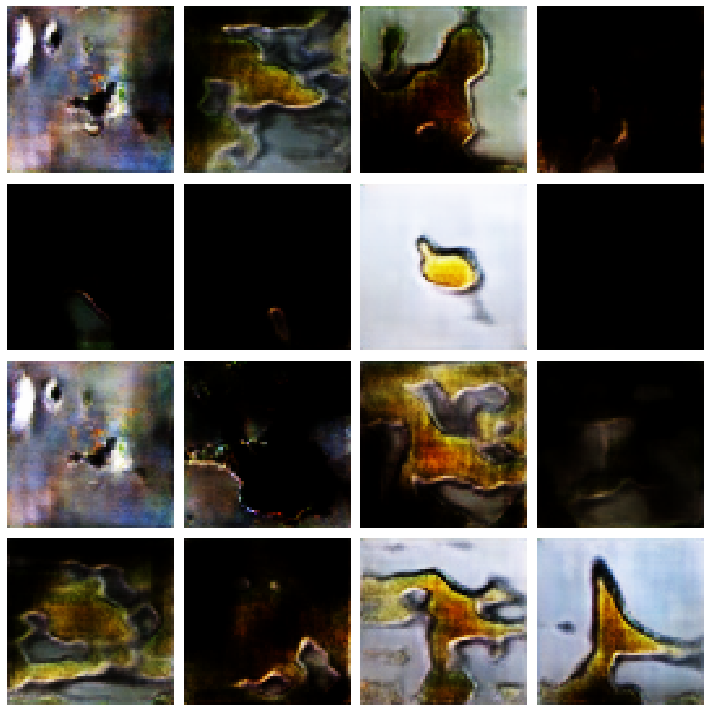

Time for epoch 195 is 19.592482566833496 sec
Time for epoch 196 is 18.666401386260986 sec
Time for epoch 197 is 18.624276399612427 sec
Time for epoch 198 is 18.548962116241455 sec
Time for epoch 199 is 18.559468030929565 sec
Time for epoch 200 is 18.59027338027954 sec
Time for epoch 201 is 18.58944845199585 sec
Time for epoch 202 is 18.634766578674316 sec
Time for epoch 203 is 18.61348819732666 sec
Time for epoch 204 is 18.605746507644653 sec
Time for epoch 205 is 18.584063291549683 sec
Time for epoch 206 is 18.60657048225403 sec
Time for epoch 207 is 18.61448049545288 sec
Time for epoch 208 is 18.63048768043518 sec
Time for epoch 209 is 18.590209007263184 sec


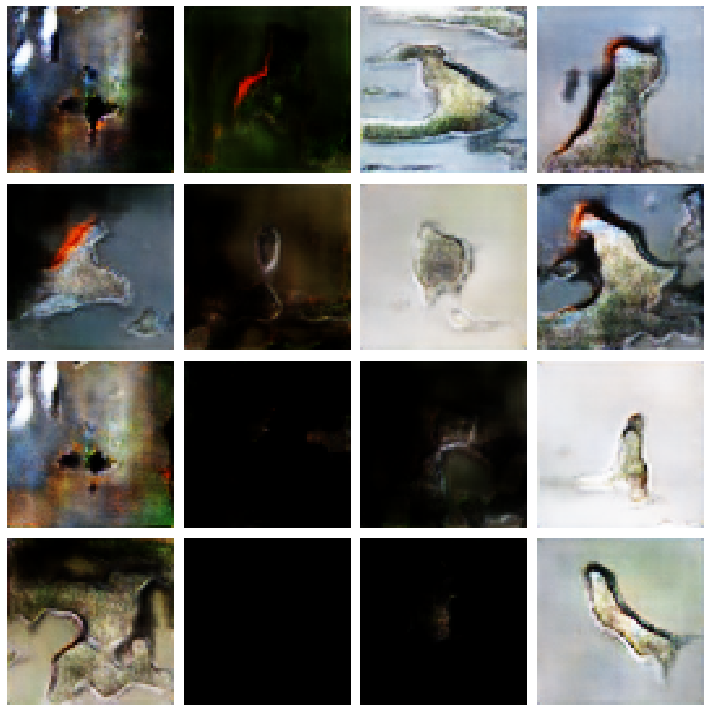

Time for epoch 210 is 19.347144603729248 sec
Time for epoch 211 is 18.63491415977478 sec
Time for epoch 212 is 18.607605695724487 sec
Time for epoch 213 is 18.660767555236816 sec
Time for epoch 214 is 18.607776641845703 sec
Time for epoch 215 is 18.542505979537964 sec
Time for epoch 216 is 18.590471744537354 sec
Time for epoch 217 is 18.63725972175598 sec
Time for epoch 218 is 18.561249256134033 sec
Time for epoch 219 is 18.553382635116577 sec
Time for epoch 220 is 18.53569531440735 sec
Time for epoch 221 is 18.616188049316406 sec
Time for epoch 222 is 18.594758987426758 sec
Time for epoch 223 is 18.60454297065735 sec
Time for epoch 224 is 18.605326175689697 sec


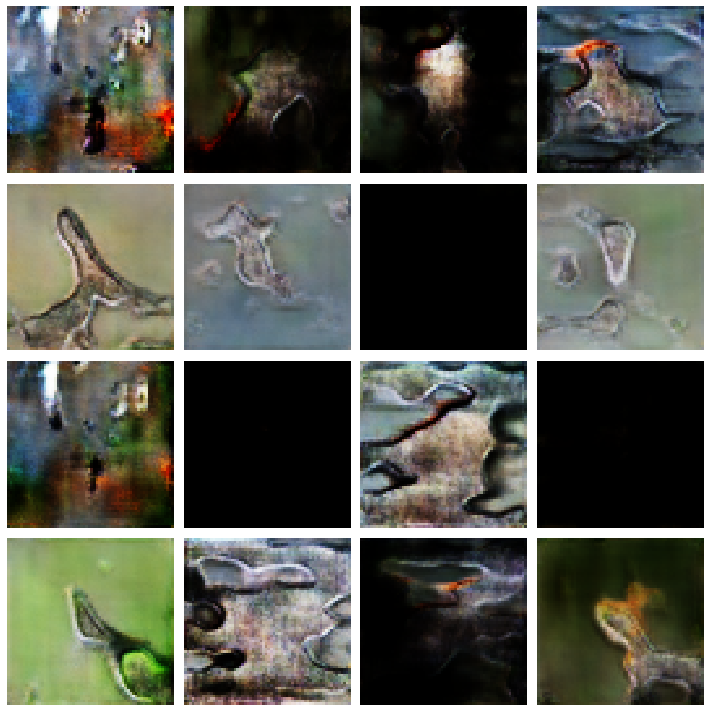

Time for epoch 225 is 19.52721929550171 sec
Time for epoch 226 is 18.646179914474487 sec
Time for epoch 227 is 18.61168336868286 sec
Time for epoch 228 is 18.638558626174927 sec
Time for epoch 229 is 18.634328365325928 sec
Time for epoch 230 is 18.601936101913452 sec
Time for epoch 231 is 18.60341191291809 sec
Time for epoch 232 is 18.651461124420166 sec
Time for epoch 233 is 18.686498403549194 sec
Time for epoch 234 is 18.59558606147766 sec
Time for epoch 235 is 18.59699559211731 sec
Time for epoch 236 is 18.544174909591675 sec
Time for epoch 237 is 18.592818021774292 sec
Time for epoch 238 is 18.551270008087158 sec
Time for epoch 239 is 18.673550367355347 sec


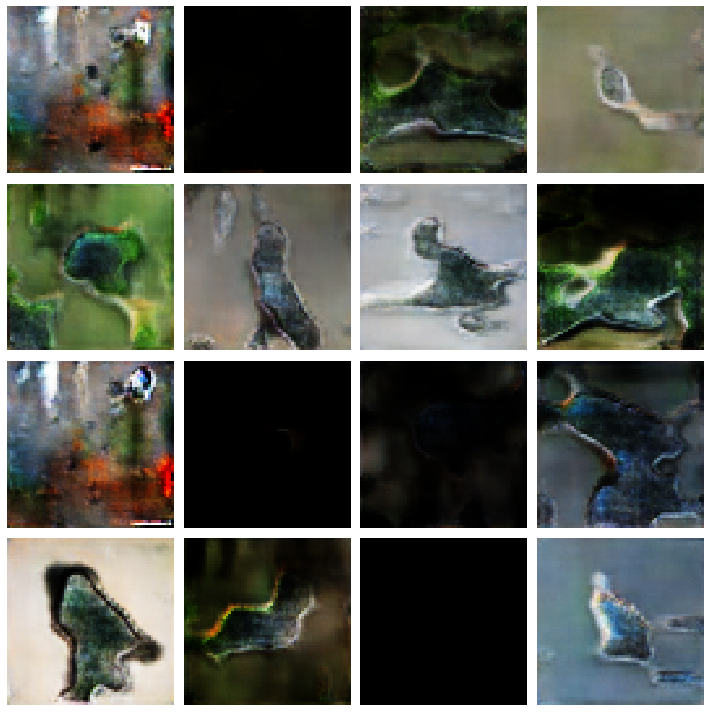

Time for epoch 240 is 19.38943600654602 sec
Time for epoch 241 is 18.690164804458618 sec
Time for epoch 242 is 18.66322898864746 sec
Time for epoch 243 is 18.65436053276062 sec
Time for epoch 244 is 18.656145811080933 sec
Time for epoch 245 is 18.66676950454712 sec
Time for epoch 246 is 18.66939878463745 sec
Time for epoch 247 is 18.661998510360718 sec
Time for epoch 248 is 18.68427038192749 sec
Time for epoch 249 is 18.658810138702393 sec
Time for epoch 250 is 18.676305532455444 sec
Time for epoch 251 is 18.674337148666382 sec
Time for epoch 252 is 18.648927688598633 sec
Time for epoch 253 is 18.64628267288208 sec
Time for epoch 254 is 18.652644634246826 sec


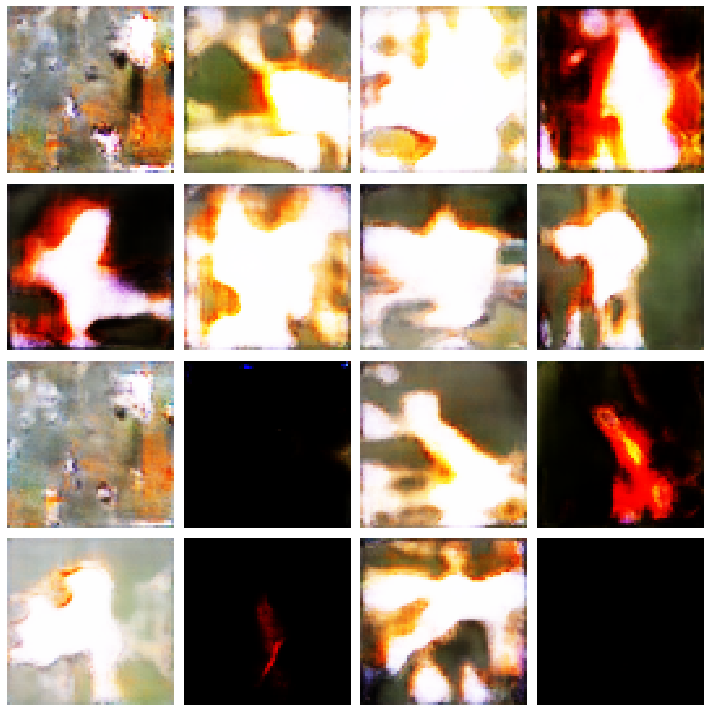

Time for epoch 255 is 19.68442678451538 sec
Time for epoch 256 is 18.656297206878662 sec
Time for epoch 257 is 18.669142246246338 sec
Time for epoch 258 is 18.69253134727478 sec
Time for epoch 259 is 18.751806020736694 sec
Time for epoch 260 is 18.68332529067993 sec
Time for epoch 261 is 18.645899772644043 sec
Time for epoch 262 is 18.63812780380249 sec
Time for epoch 263 is 18.620612144470215 sec
Time for epoch 264 is 18.710774421691895 sec
Time for epoch 265 is 18.64432406425476 sec
Time for epoch 266 is 18.66851305961609 sec
Time for epoch 267 is 18.669604301452637 sec
Time for epoch 268 is 18.713380813598633 sec
Time for epoch 269 is 18.70927596092224 sec


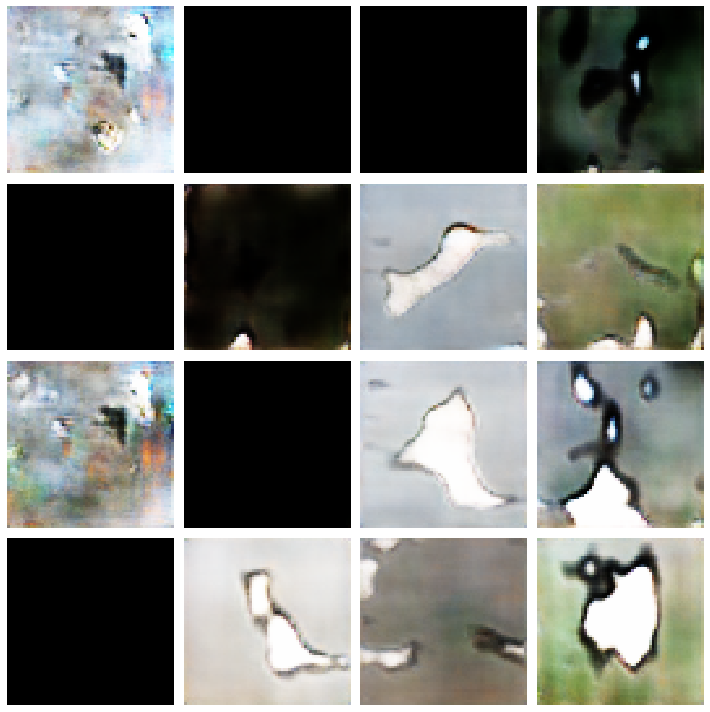

Time for epoch 270 is 19.499202251434326 sec
Time for epoch 271 is 18.68601894378662 sec
Time for epoch 272 is 18.64864206314087 sec
Time for epoch 273 is 18.638001680374146 sec
Time for epoch 274 is 18.63082194328308 sec
Time for epoch 275 is 18.662391424179077 sec
Time for epoch 276 is 18.676913022994995 sec
Time for epoch 277 is 18.6483633518219 sec
Time for epoch 278 is 18.642127990722656 sec
Time for epoch 279 is 18.616538763046265 sec
Time for epoch 280 is 18.65885019302368 sec
Time for epoch 281 is 18.652695417404175 sec
Time for epoch 282 is 18.602160215377808 sec
Time for epoch 283 is 18.619065761566162 sec
Time for epoch 284 is 18.62276792526245 sec


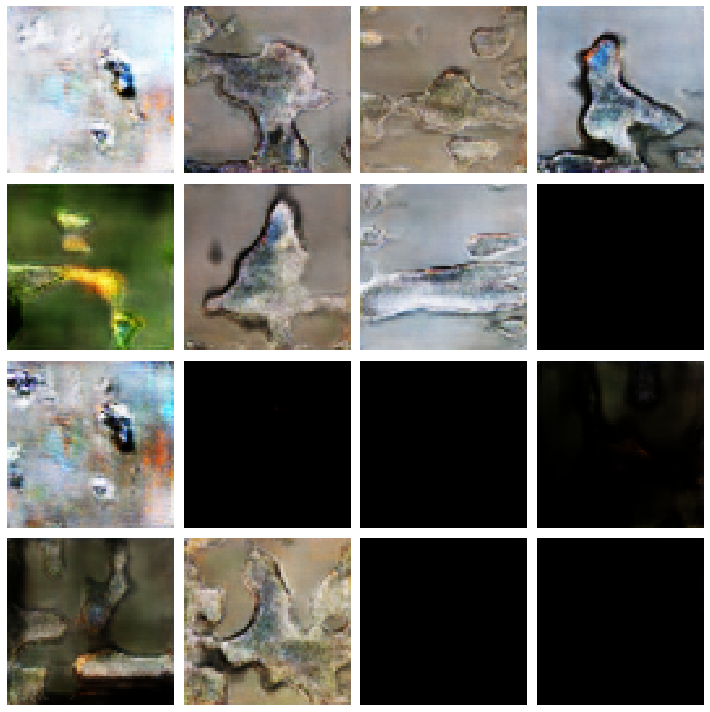

Time for epoch 285 is 19.44181227684021 sec
Time for epoch 286 is 18.699997663497925 sec
Time for epoch 287 is 18.758118391036987 sec
Time for epoch 288 is 18.645766735076904 sec
Time for epoch 289 is 18.616679906845093 sec
Time for epoch 290 is 18.575713872909546 sec
Time for epoch 291 is 18.621221780776978 sec
Time for epoch 292 is 18.576868534088135 sec
Time for epoch 293 is 18.616689443588257 sec
Time for epoch 294 is 18.625551223754883 sec
Time for epoch 295 is 18.617393016815186 sec
Time for epoch 296 is 18.630834341049194 sec
Time for epoch 297 is 18.693400382995605 sec
Time for epoch 298 is 18.722266674041748 sec
Time for epoch 299 is 18.69737434387207 sec


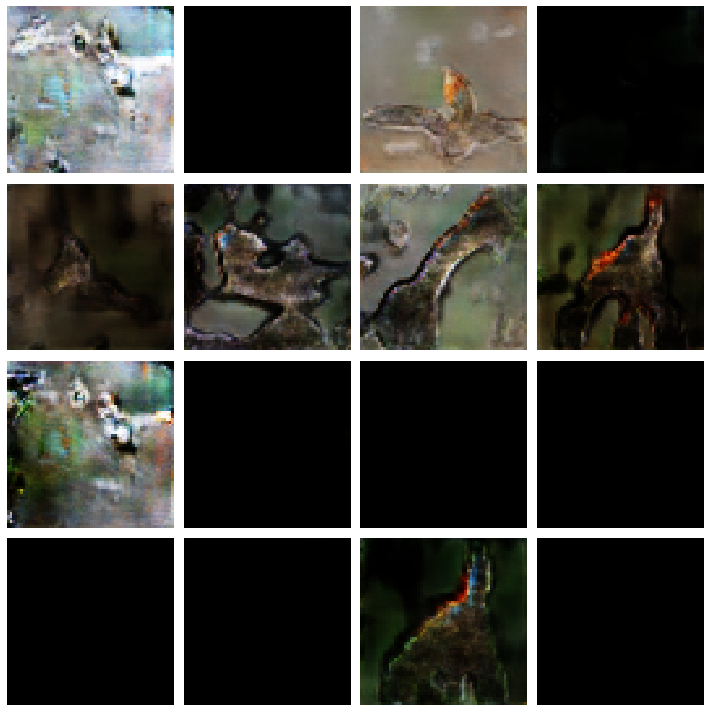

Time for epoch 300 is 19.437254905700684 sec
Time for epoch 301 is 18.720110177993774 sec
Time for epoch 302 is 18.718894243240356 sec
Time for epoch 303 is 18.663941383361816 sec
Time for epoch 304 is 18.69012999534607 sec
Time for epoch 305 is 18.697712421417236 sec
Time for epoch 306 is 18.692005395889282 sec
Time for epoch 307 is 18.687479734420776 sec
Time for epoch 308 is 18.67213225364685 sec
Time for epoch 309 is 18.68157982826233 sec
Time for epoch 310 is 18.6576087474823 sec
Time for epoch 311 is 18.656240224838257 sec
Time for epoch 312 is 18.653050422668457 sec
Time for epoch 313 is 18.681162118911743 sec
Time for epoch 314 is 18.71483826637268 sec


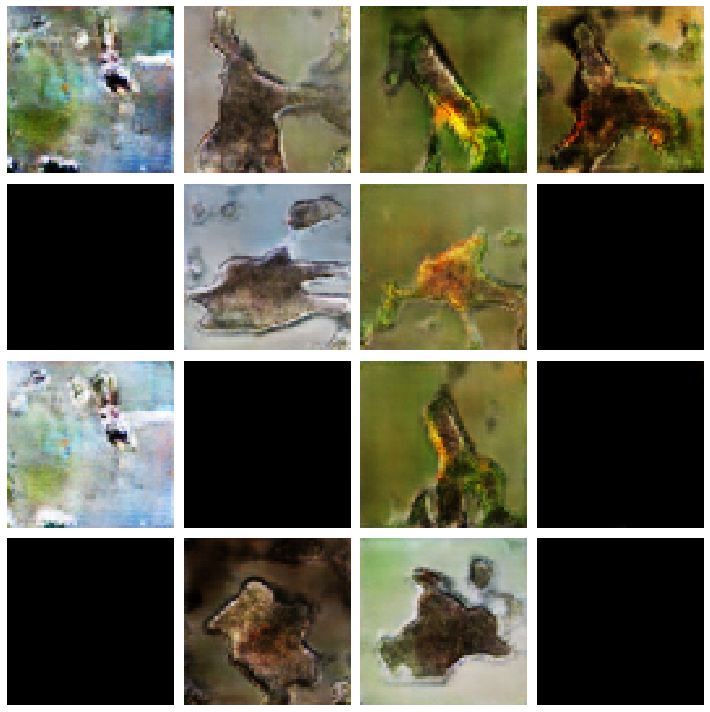

Time for epoch 315 is 19.622231245040894 sec
Time for epoch 316 is 18.70191478729248 sec
Time for epoch 317 is 18.7184419631958 sec
Time for epoch 318 is 18.673253774642944 sec
Time for epoch 319 is 18.666343212127686 sec
Time for epoch 320 is 18.66184687614441 sec
Time for epoch 321 is 18.708576202392578 sec
Time for epoch 322 is 18.657792329788208 sec
Time for epoch 323 is 18.6588933467865 sec
Time for epoch 324 is 18.664231538772583 sec
Time for epoch 325 is 18.666507482528687 sec
Time for epoch 326 is 18.697920083999634 sec
Time for epoch 327 is 18.721590042114258 sec
Time for epoch 328 is 18.705504179000854 sec
Time for epoch 329 is 18.653634309768677 sec


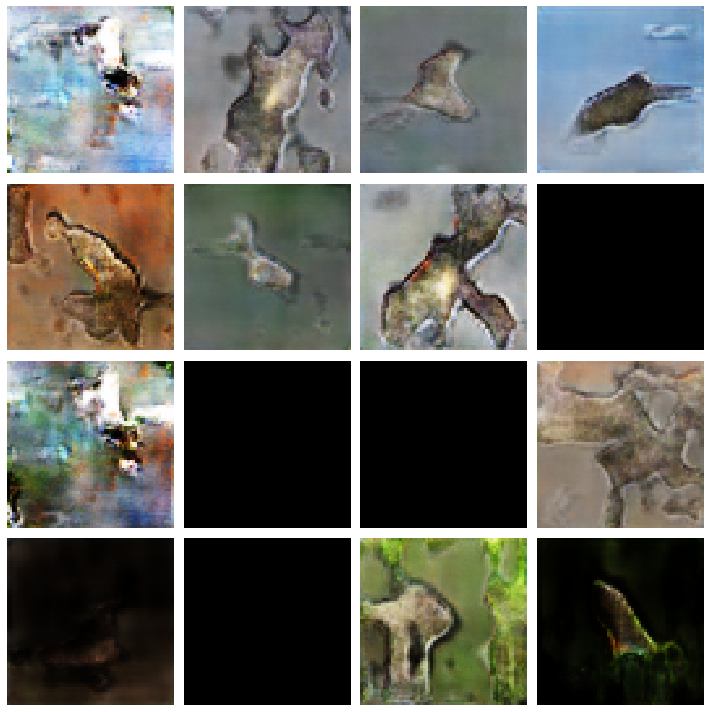

Time for epoch 330 is 19.48701000213623 sec
Time for epoch 331 is 18.768745183944702 sec
Time for epoch 332 is 18.715559720993042 sec
Time for epoch 333 is 18.72659158706665 sec
Time for epoch 334 is 18.72607398033142 sec
Time for epoch 335 is 18.71713423728943 sec
Time for epoch 336 is 18.674437999725342 sec
Time for epoch 337 is 18.699404001235962 sec
Time for epoch 338 is 18.6511869430542 sec
Time for epoch 339 is 18.684566736221313 sec
Time for epoch 340 is 18.671470642089844 sec
Time for epoch 341 is 18.614503860473633 sec
Time for epoch 342 is 18.6579270362854 sec
Time for epoch 343 is 18.686125993728638 sec
Time for epoch 344 is 18.667458295822144 sec


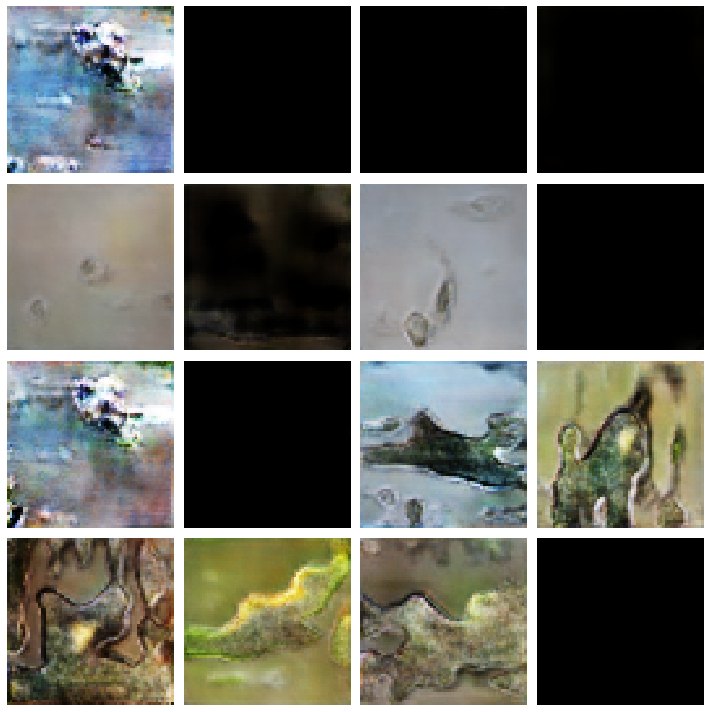

Time for epoch 345 is 19.404029607772827 sec
Time for epoch 346 is 18.662991285324097 sec
Time for epoch 347 is 18.678870916366577 sec
Time for epoch 348 is 18.69033122062683 sec
Time for epoch 349 is 18.683863639831543 sec
Time for epoch 350 is 18.672990322113037 sec
Time for epoch 351 is 18.63738775253296 sec
Time for epoch 352 is 18.61915111541748 sec
Time for epoch 353 is 18.618425846099854 sec
Time for epoch 354 is 18.65104389190674 sec
Time for epoch 355 is 18.643630981445312 sec
Time for epoch 356 is 18.642820596694946 sec
Time for epoch 357 is 18.67120599746704 sec
Time for epoch 358 is 18.660818576812744 sec
Time for epoch 359 is 18.673096179962158 sec


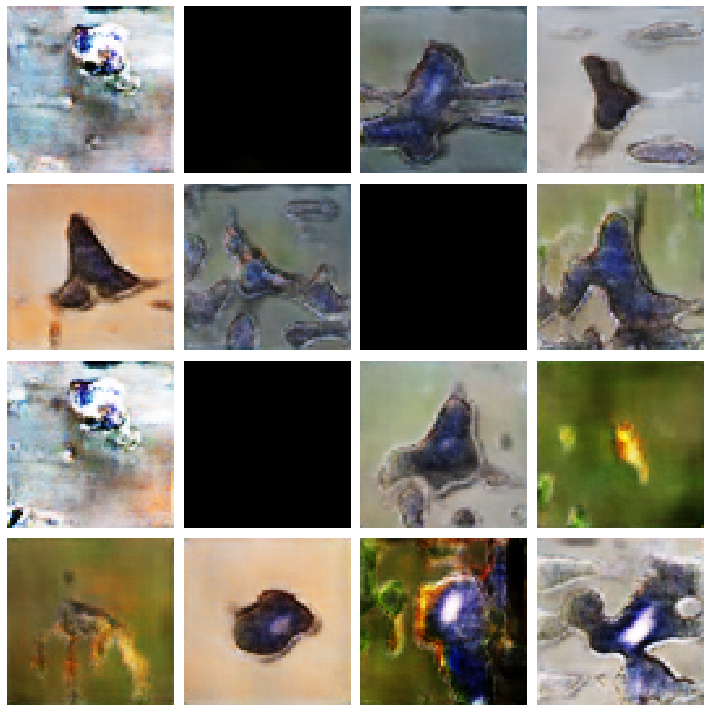

Time for epoch 360 is 19.478392124176025 sec
Time for epoch 361 is 18.672457456588745 sec
Time for epoch 362 is 18.691895484924316 sec
Time for epoch 363 is 18.67315673828125 sec
Time for epoch 364 is 18.61503553390503 sec
Time for epoch 365 is 18.690555810928345 sec
Time for epoch 366 is 18.65374445915222 sec
Time for epoch 367 is 18.6763277053833 sec
Time for epoch 368 is 18.631511449813843 sec
Time for epoch 369 is 18.641030311584473 sec
Time for epoch 370 is 18.6623797416687 sec
Time for epoch 371 is 18.65860867500305 sec
Time for epoch 372 is 18.683012008666992 sec
Time for epoch 373 is 18.684672832489014 sec
Time for epoch 374 is 18.644978761672974 sec


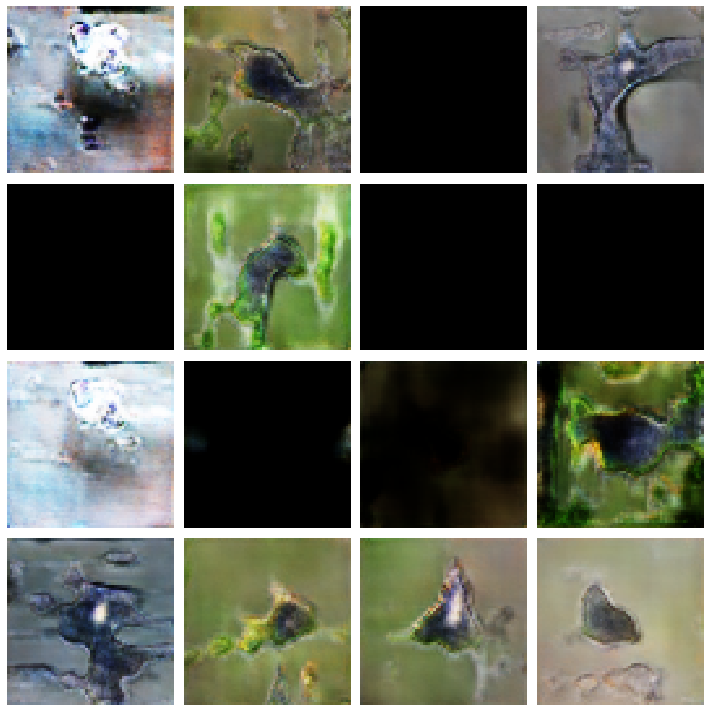

Time for epoch 375 is 19.601412773132324 sec
Time for epoch 376 is 18.65756916999817 sec
Time for epoch 377 is 18.62631058692932 sec
Time for epoch 378 is 18.685345888137817 sec
Time for epoch 379 is 18.69793152809143 sec
Time for epoch 380 is 18.64116334915161 sec
Time for epoch 381 is 18.653536558151245 sec
Time for epoch 382 is 18.656360149383545 sec
Time for epoch 383 is 18.65502095222473 sec
Time for epoch 384 is 18.674935340881348 sec
Time for epoch 385 is 18.634448289871216 sec
Time for epoch 386 is 18.643314838409424 sec
Time for epoch 387 is 18.659563779830933 sec
Time for epoch 388 is 18.69241690635681 sec
Time for epoch 389 is 18.734970092773438 sec


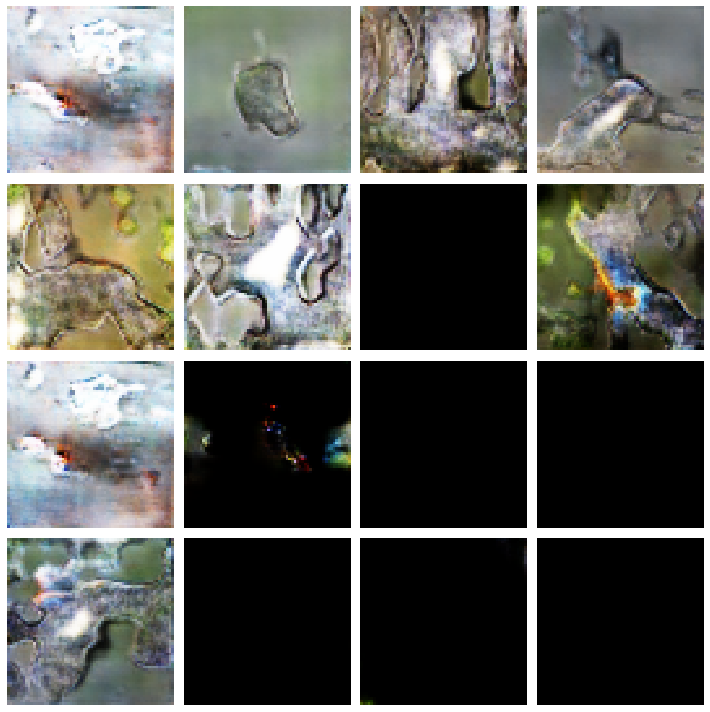

Time for epoch 390 is 19.377586364746094 sec
Time for epoch 391 is 18.659512758255005 sec
Time for epoch 392 is 18.580668687820435 sec
Time for epoch 393 is 18.64182996749878 sec
Time for epoch 394 is 18.60594415664673 sec
Time for epoch 395 is 18.651531457901 sec
Time for epoch 396 is 18.67913818359375 sec
Time for epoch 397 is 18.67314577102661 sec
Time for epoch 398 is 18.712226629257202 sec
Time for epoch 399 is 18.66217803955078 sec
Time for epoch 400 is 18.68485927581787 sec
Time for epoch 401 is 18.679171085357666 sec
Time for epoch 402 is 18.680434942245483 sec
Time for epoch 403 is 18.66365671157837 sec
Time for epoch 404 is 18.67989158630371 sec


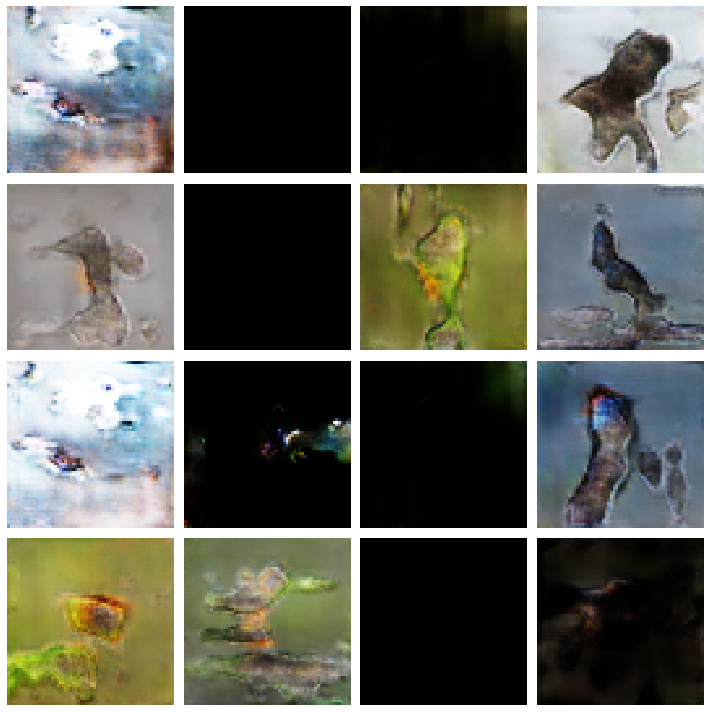

Time for epoch 405 is 19.424428462982178 sec
Time for epoch 406 is 18.698752641677856 sec
Time for epoch 407 is 18.664788007736206 sec
Time for epoch 408 is 18.660045623779297 sec
Time for epoch 409 is 18.70075273513794 sec
Time for epoch 410 is 18.69071936607361 sec
Time for epoch 411 is 18.65929627418518 sec
Time for epoch 412 is 18.66208577156067 sec
Time for epoch 413 is 18.637938976287842 sec
Time for epoch 414 is 18.616612672805786 sec
Time for epoch 415 is 18.63951826095581 sec
Time for epoch 416 is 18.627346754074097 sec
Time for epoch 417 is 18.651984453201294 sec
Time for epoch 418 is 18.667444229125977 sec
Time for epoch 419 is 18.6888370513916 sec


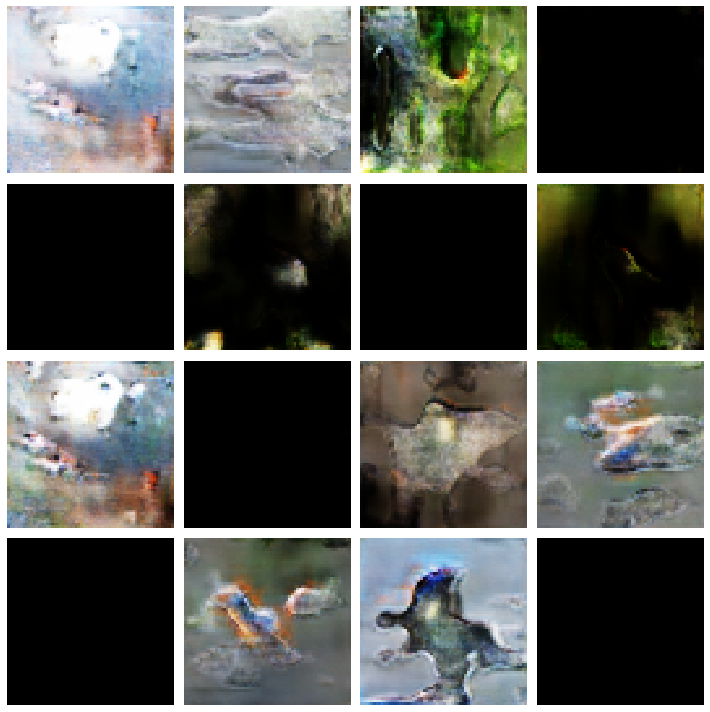

Time for epoch 420 is 19.450494050979614 sec
Time for epoch 421 is 18.671834707260132 sec
Time for epoch 422 is 18.67116665840149 sec
Time for epoch 423 is 18.68807816505432 sec
Time for epoch 424 is 18.6643168926239 sec
Time for epoch 425 is 18.68207550048828 sec
Time for epoch 426 is 18.676997423171997 sec
Time for epoch 427 is 18.670581579208374 sec
Time for epoch 428 is 18.643170833587646 sec
Time for epoch 429 is 18.665611267089844 sec
Time for epoch 430 is 18.688485622406006 sec
Time for epoch 431 is 18.649239778518677 sec
Time for epoch 432 is 18.669608116149902 sec
Time for epoch 433 is 18.685311317443848 sec
Time for epoch 434 is 18.666594982147217 sec


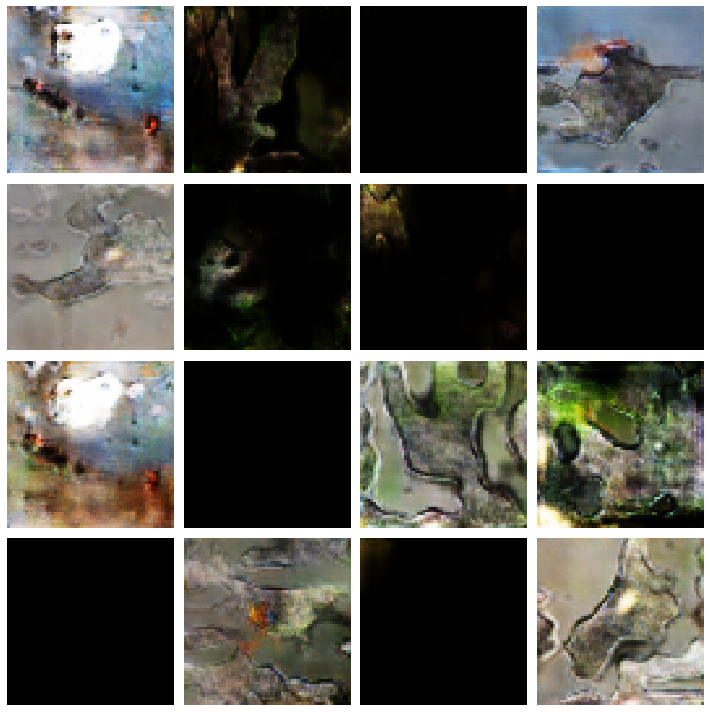

Time for epoch 435 is 19.639522314071655 sec
Time for epoch 436 is 18.685664176940918 sec
Time for epoch 437 is 18.625582933425903 sec
Time for epoch 438 is 18.626497507095337 sec
Time for epoch 439 is 18.625349283218384 sec
Time for epoch 440 is 18.62740397453308 sec
Time for epoch 441 is 18.615015506744385 sec
Time for epoch 442 is 18.633622646331787 sec
Time for epoch 443 is 18.59819793701172 sec
Time for epoch 444 is 18.634186267852783 sec
Time for epoch 445 is 18.659220218658447 sec
Time for epoch 446 is 18.617082834243774 sec
Time for epoch 447 is 18.647425174713135 sec
Time for epoch 448 is 18.676406860351562 sec
Time for epoch 449 is 18.71017026901245 sec


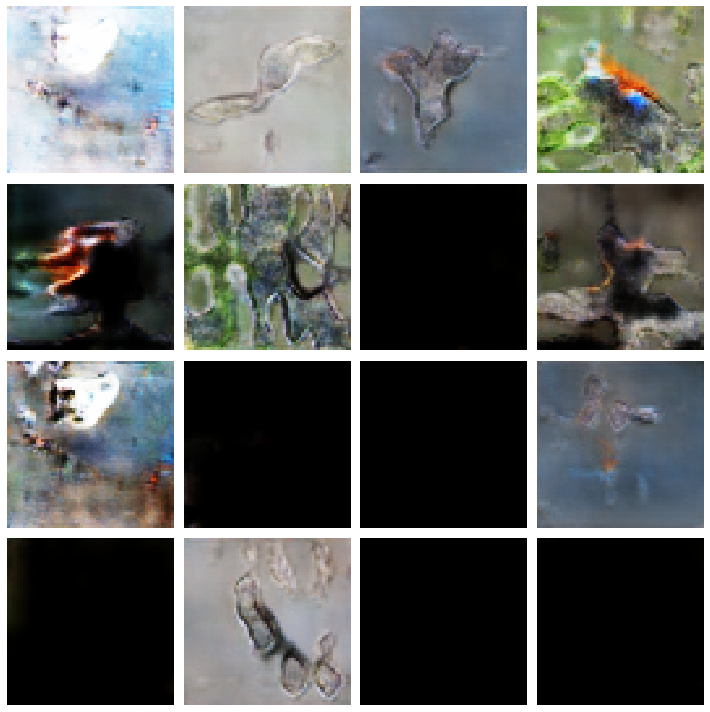

Time for epoch 450 is 19.446160078048706 sec
Time for epoch 451 is 18.6996009349823 sec
Time for epoch 452 is 18.664283514022827 sec
Time for epoch 453 is 18.712201356887817 sec
Time for epoch 454 is 18.64830183982849 sec
Time for epoch 455 is 18.6632719039917 sec
Time for epoch 456 is 18.63686180114746 sec
Time for epoch 457 is 18.68714189529419 sec
Time for epoch 458 is 18.67950701713562 sec
Time for epoch 459 is 18.677302598953247 sec
Time for epoch 460 is 18.70163607597351 sec
Time for epoch 461 is 18.656595945358276 sec
Time for epoch 462 is 18.646329402923584 sec
Time for epoch 463 is 18.622891664505005 sec
Time for epoch 464 is 18.64214777946472 sec


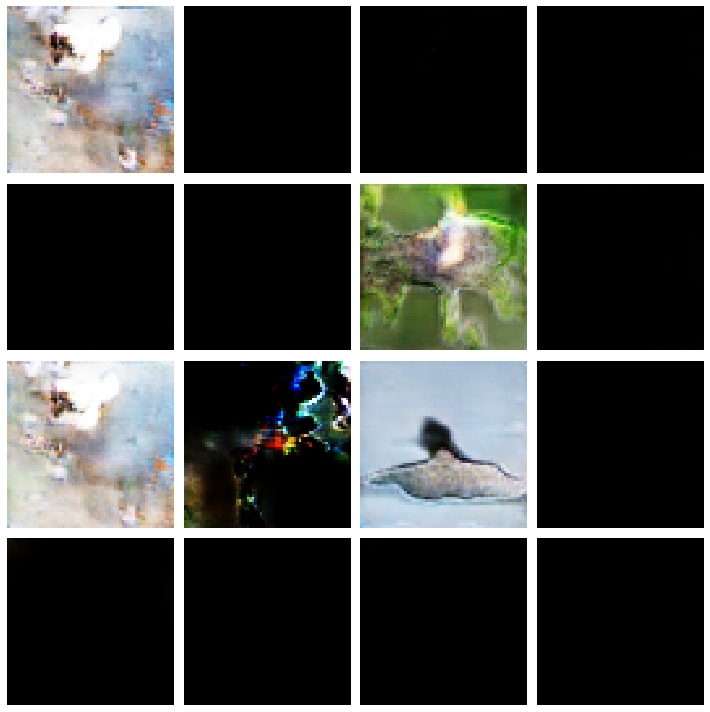

Time for epoch 465 is 19.375069856643677 sec
Time for epoch 466 is 18.66704249382019 sec
Time for epoch 467 is 18.651126623153687 sec
Time for epoch 468 is 18.6454017162323 sec
Time for epoch 469 is 18.6369526386261 sec
Time for epoch 470 is 18.59484314918518 sec
Time for epoch 471 is 18.61187505722046 sec
Time for epoch 472 is 18.572261810302734 sec
Time for epoch 473 is 18.6246497631073 sec
Time for epoch 474 is 18.61884045600891 sec
Time for epoch 475 is 18.59927272796631 sec
Time for epoch 476 is 18.607367277145386 sec
Time for epoch 477 is 18.609743356704712 sec
Time for epoch 478 is 18.640740394592285 sec
Time for epoch 479 is 18.672877311706543 sec


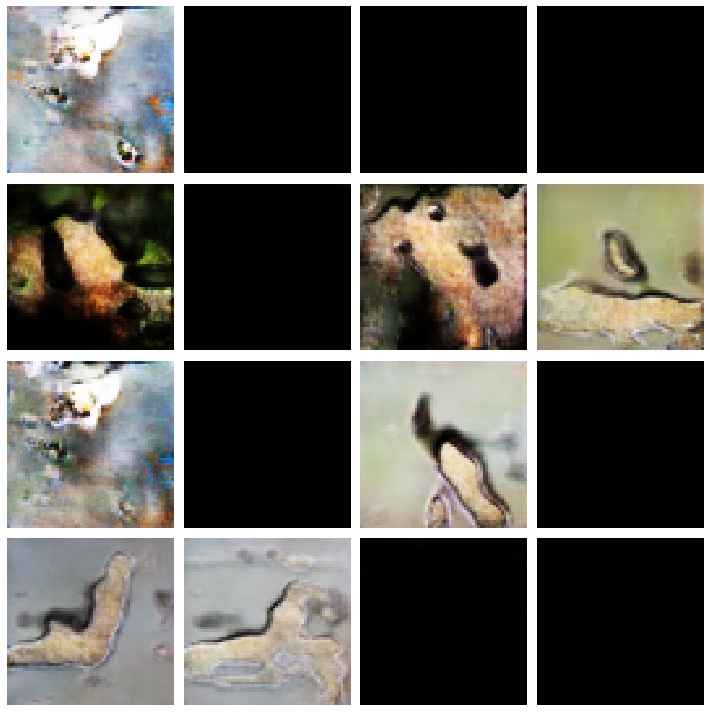

Time for epoch 480 is 19.407925128936768 sec
Time for epoch 481 is 18.64742159843445 sec
Time for epoch 482 is 18.62672996520996 sec
Time for epoch 483 is 18.64384937286377 sec
Time for epoch 484 is 18.63589382171631 sec
Time for epoch 485 is 18.664833545684814 sec
Time for epoch 486 is 18.670785427093506 sec
Time for epoch 487 is 18.654399394989014 sec
Time for epoch 488 is 18.6451358795166 sec
Time for epoch 489 is 18.704176902770996 sec
Time for epoch 490 is 18.64431619644165 sec
Time for epoch 491 is 18.664873361587524 sec
Time for epoch 492 is 18.69697141647339 sec
Time for epoch 493 is 18.668912649154663 sec
Time for epoch 494 is 18.66824221611023 sec


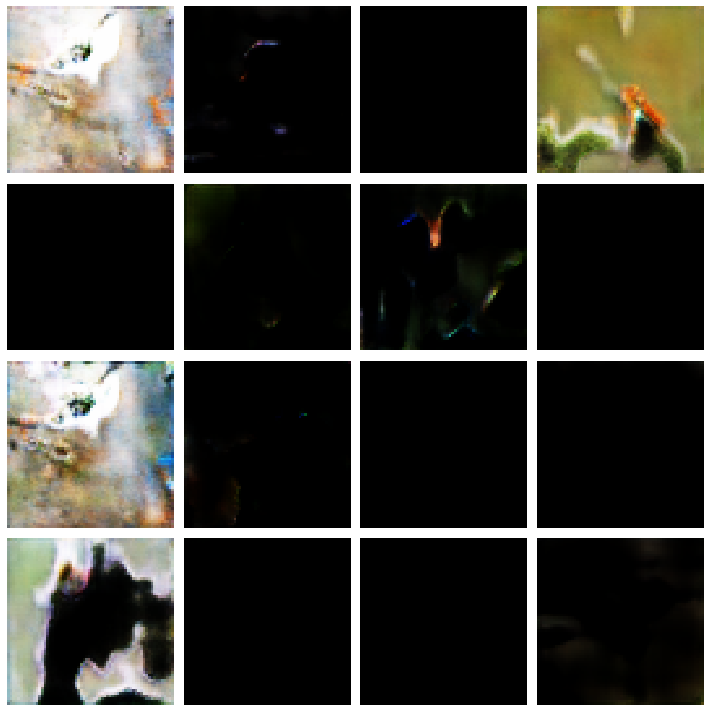

Time for epoch 495 is 19.60560131072998 sec
Time for epoch 496 is 18.67334508895874 sec
Time for epoch 497 is 18.64109778404236 sec
Time for epoch 498 is 18.712789058685303 sec
Time for epoch 499 is 18.638513326644897 sec
Time for epoch 500 is 18.62675404548645 sec
Time for epoch 501 is 18.611973524093628 sec
Time for epoch 502 is 18.670671224594116 sec
Time for epoch 503 is 18.636848211288452 sec
Time for epoch 504 is 18.635198831558228 sec
Time for epoch 505 is 18.670003175735474 sec
Time for epoch 506 is 18.657395839691162 sec
Time for epoch 507 is 18.6534264087677 sec
Time for epoch 508 is 18.606523036956787 sec
Time for epoch 509 is 18.58907985687256 sec


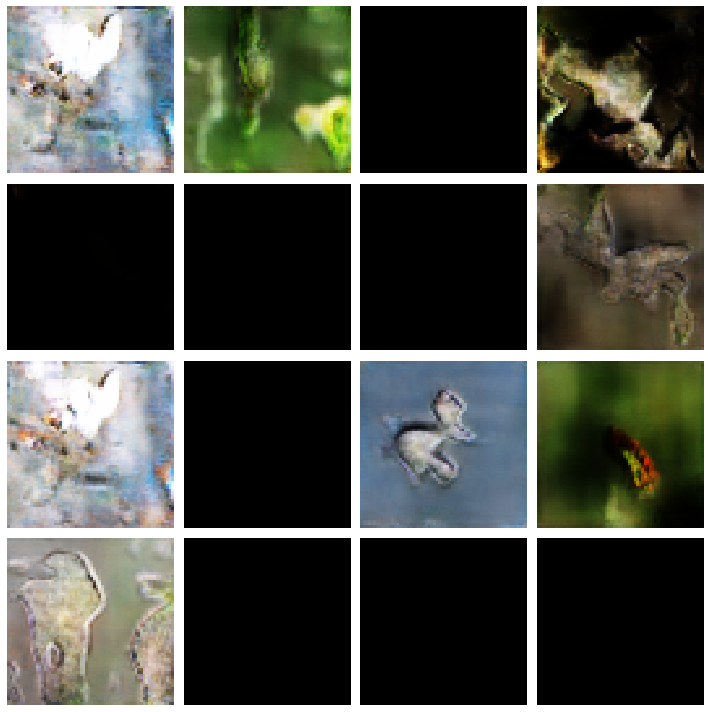

Time for epoch 510 is 19.3686363697052 sec
Time for epoch 511 is 18.681772708892822 sec
Time for epoch 512 is 18.59510850906372 sec
Time for epoch 513 is 18.590675592422485 sec
Time for epoch 514 is 18.649964570999146 sec
Time for epoch 515 is 18.659528493881226 sec
Time for epoch 516 is 18.63956904411316 sec
Time for epoch 517 is 18.633000373840332 sec
Time for epoch 518 is 18.65938425064087 sec
Time for epoch 519 is 18.674561500549316 sec
Time for epoch 520 is 18.639270305633545 sec
Time for epoch 521 is 18.719935655593872 sec
Time for epoch 522 is 18.660212993621826 sec
Time for epoch 523 is 18.693673133850098 sec
Time for epoch 524 is 18.64858317375183 sec


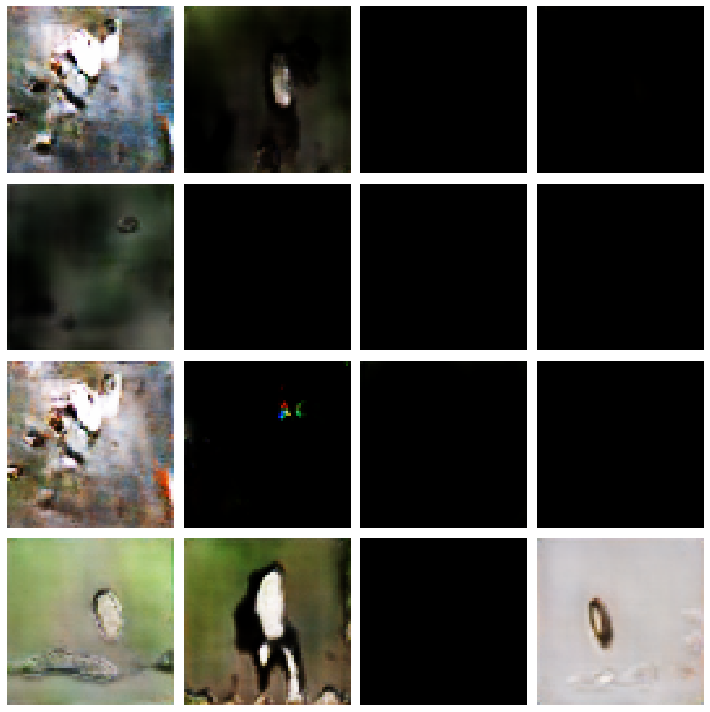

Time for epoch 525 is 19.41716432571411 sec
Time for epoch 526 is 18.634830474853516 sec
Time for epoch 527 is 18.60897994041443 sec
Time for epoch 528 is 18.637446403503418 sec
Time for epoch 529 is 18.624290704727173 sec
Time for epoch 530 is 18.600818395614624 sec
Time for epoch 531 is 18.61166787147522 sec
Time for epoch 532 is 18.586333990097046 sec
Time for epoch 533 is 18.57560920715332 sec
Time for epoch 534 is 18.614006996154785 sec
Time for epoch 535 is 18.61029815673828 sec
Time for epoch 536 is 18.58843755722046 sec
Time for epoch 537 is 18.654265880584717 sec
Time for epoch 538 is 18.63230538368225 sec
Time for epoch 539 is 18.62645936012268 sec


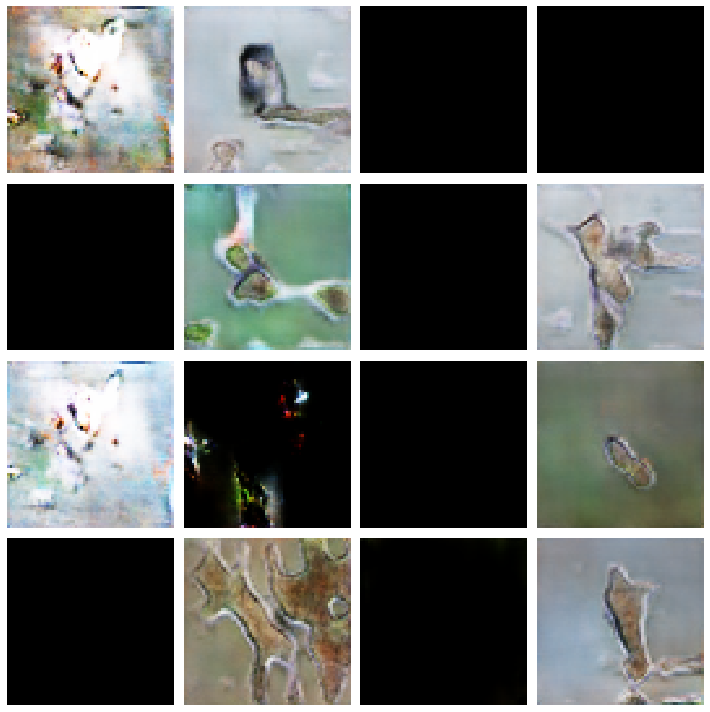

Time for epoch 540 is 19.287271976470947 sec
Time for epoch 541 is 18.584702253341675 sec
Time for epoch 542 is 18.626516103744507 sec
Time for epoch 543 is 18.704437971115112 sec
Time for epoch 544 is 18.611027479171753 sec
Time for epoch 545 is 18.57206392288208 sec
Time for epoch 546 is 18.621488332748413 sec
Time for epoch 547 is 18.586756229400635 sec
Time for epoch 548 is 18.591959476470947 sec
Time for epoch 549 is 18.60111951828003 sec
Time for epoch 550 is 18.660818576812744 sec
Time for epoch 551 is 18.603309154510498 sec
Time for epoch 552 is 18.633931875228882 sec
Time for epoch 553 is 18.6281795501709 sec
Time for epoch 554 is 18.552237272262573 sec


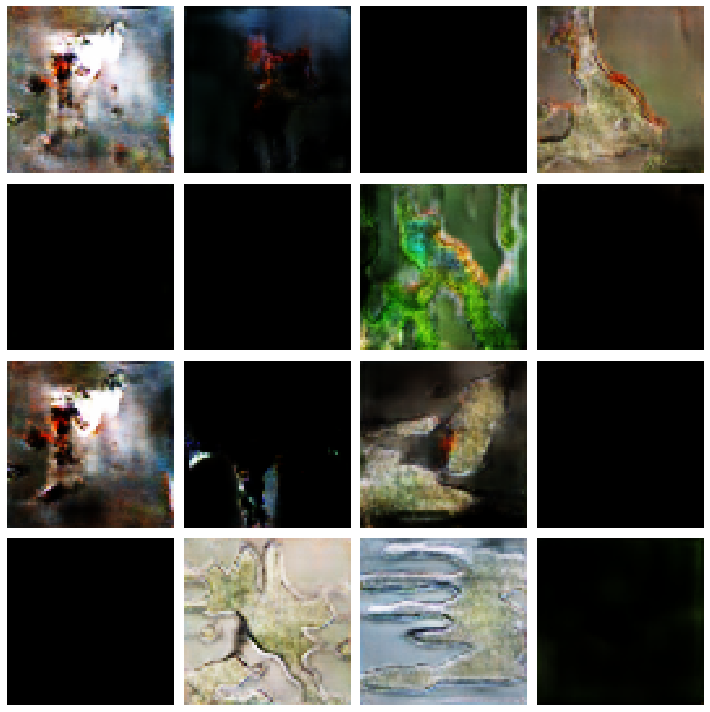

Time for epoch 555 is 19.453142166137695 sec
Time for epoch 556 is 18.571415185928345 sec
Time for epoch 557 is 18.559753894805908 sec
Time for epoch 558 is 18.58334970474243 sec
Time for epoch 559 is 18.58994770050049 sec
Time for epoch 560 is 18.56913709640503 sec
Time for epoch 561 is 18.557383060455322 sec
Time for epoch 562 is 18.59005880355835 sec
Time for epoch 563 is 18.6046724319458 sec
Time for epoch 564 is 18.681931018829346 sec
Time for epoch 565 is 18.62925124168396 sec
Time for epoch 566 is 18.596622705459595 sec
Time for epoch 567 is 18.569599628448486 sec
Time for epoch 568 is 18.58584690093994 sec
Time for epoch 569 is 18.580345630645752 sec


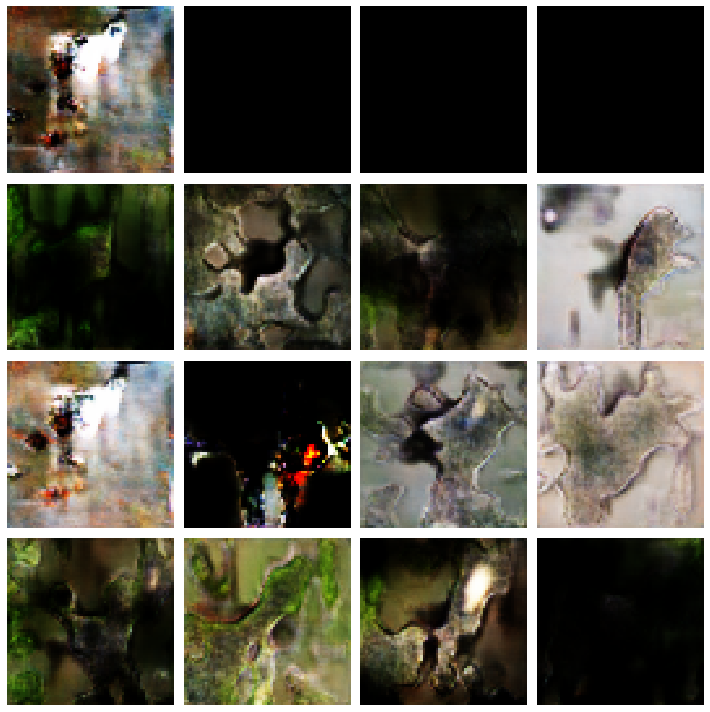

Time for epoch 570 is 19.275460481643677 sec
Time for epoch 571 is 18.542505741119385 sec
Time for epoch 572 is 18.57288360595703 sec
Time for epoch 573 is 18.590873956680298 sec
Time for epoch 574 is 18.612472772598267 sec
Time for epoch 575 is 18.603314638137817 sec
Time for epoch 576 is 18.598005056381226 sec
Time for epoch 577 is 18.592087745666504 sec
Time for epoch 578 is 18.59165048599243 sec
Time for epoch 579 is 18.565991640090942 sec
Time for epoch 580 is 18.552513122558594 sec
Time for epoch 581 is 18.55824875831604 sec
Time for epoch 582 is 18.575716733932495 sec
Time for epoch 583 is 18.567039489746094 sec
Time for epoch 584 is 18.5433132648468 sec


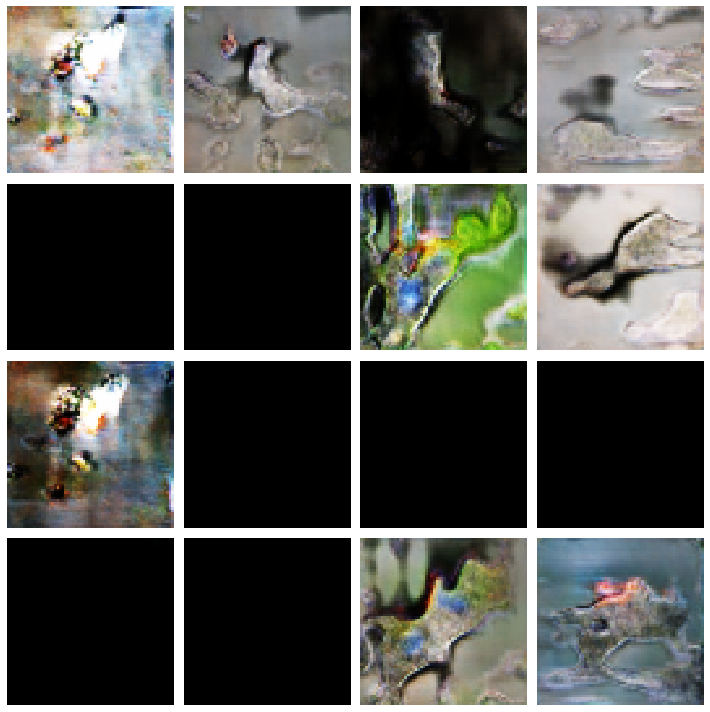

Time for epoch 585 is 19.27654194831848 sec
Time for epoch 586 is 18.544432401657104 sec
Time for epoch 587 is 18.55794906616211 sec
Time for epoch 588 is 18.63341212272644 sec
Time for epoch 589 is 18.595606565475464 sec
Time for epoch 590 is 18.564202070236206 sec
Time for epoch 591 is 18.588648557662964 sec
Time for epoch 592 is 18.554094552993774 sec
Time for epoch 593 is 18.637011766433716 sec
Time for epoch 594 is 18.593557834625244 sec
Time for epoch 595 is 18.571021556854248 sec
Time for epoch 596 is 18.534392595291138 sec
Time for epoch 597 is 18.53458881378174 sec
Time for epoch 598 is 18.514405250549316 sec
Time for epoch 599 is 18.525596380233765 sec


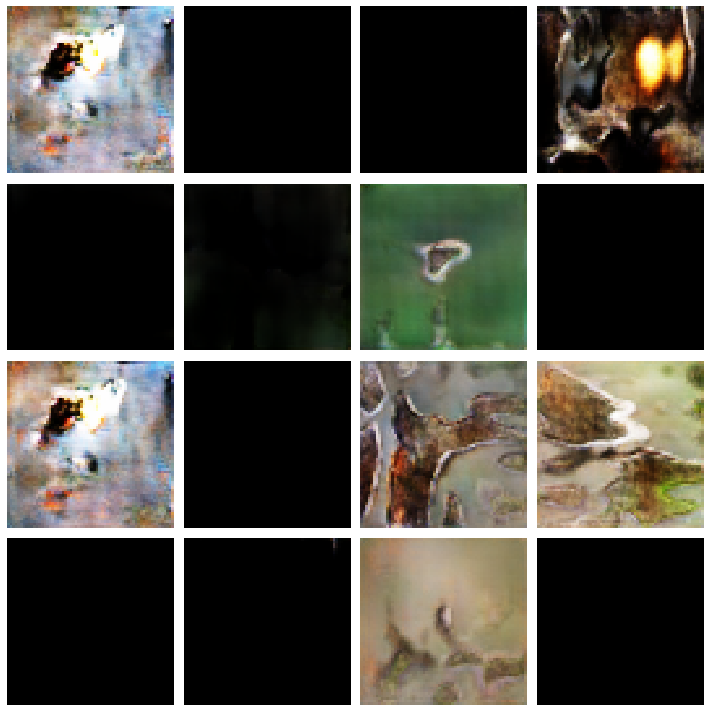

Time for epoch 600 is 19.246885299682617 sec
Time for epoch 601 is 18.534589529037476 sec
Time for epoch 602 is 18.57241129875183 sec
Time for epoch 603 is 18.585057735443115 sec
Time for epoch 604 is 18.61504554748535 sec
Time for epoch 605 is 18.573407411575317 sec
Time for epoch 606 is 18.55324387550354 sec
Time for epoch 607 is 18.512133836746216 sec
Time for epoch 608 is 18.56570553779602 sec
Time for epoch 609 is 18.529742002487183 sec
Time for epoch 610 is 18.536255598068237 sec
Time for epoch 611 is 18.49383020401001 sec
Time for epoch 612 is 18.60050106048584 sec
Time for epoch 613 is 18.55298137664795 sec
Time for epoch 614 is 18.56310248374939 sec


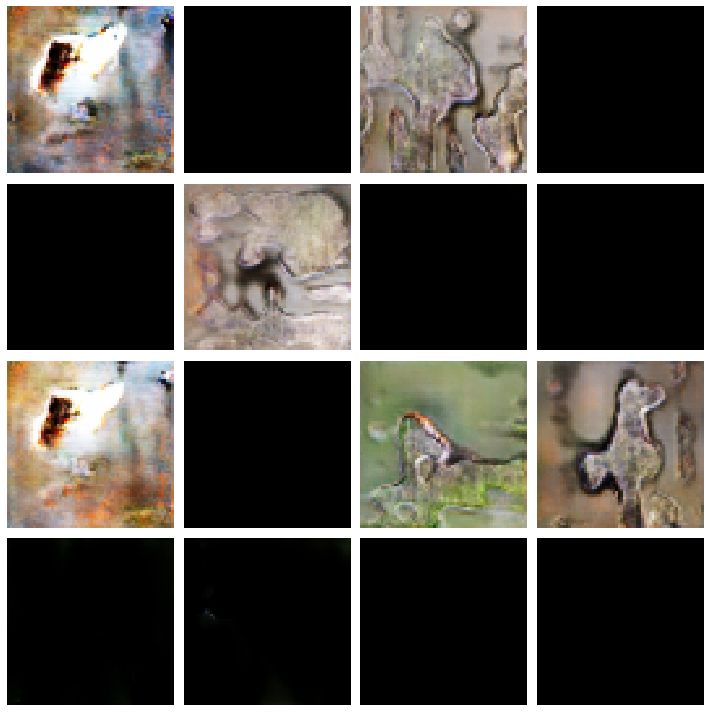

Time for epoch 615 is 19.45482587814331 sec
Time for epoch 616 is 18.536503314971924 sec
Time for epoch 617 is 18.608009338378906 sec
Time for epoch 618 is 18.598803281784058 sec
Time for epoch 619 is 18.573612451553345 sec
Time for epoch 620 is 18.591559171676636 sec
Time for epoch 621 is 18.59152102470398 sec
Time for epoch 622 is 18.708986520767212 sec
Time for epoch 623 is 18.579832553863525 sec
Time for epoch 624 is 18.571932315826416 sec
Time for epoch 625 is 18.585272789001465 sec
Time for epoch 626 is 18.618446111679077 sec
Time for epoch 627 is 18.617964267730713 sec
Time for epoch 628 is 18.61909556388855 sec
Time for epoch 629 is 18.572973489761353 sec


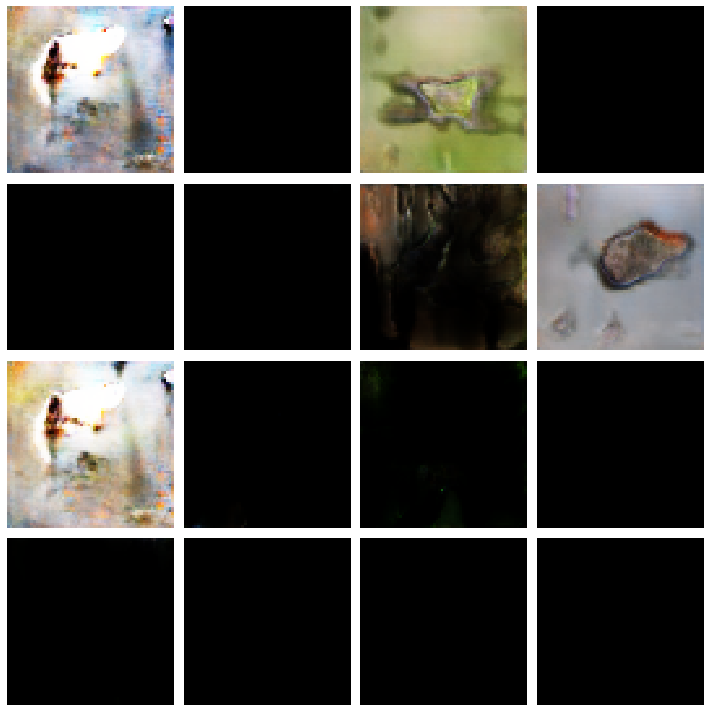

Time for epoch 630 is 19.18519902229309 sec
Time for epoch 631 is 18.60658550262451 sec
Time for epoch 632 is 18.54244327545166 sec
Time for epoch 633 is 18.58237624168396 sec
Time for epoch 634 is 18.637746810913086 sec
Time for epoch 635 is 18.5684335231781 sec
Time for epoch 636 is 18.566009521484375 sec
Time for epoch 637 is 18.55178213119507 sec
Time for epoch 638 is 18.554199934005737 sec
Time for epoch 639 is 18.549415826797485 sec
Time for epoch 640 is 18.53011918067932 sec
Time for epoch 641 is 18.52739191055298 sec
Time for epoch 642 is 18.550516366958618 sec
Time for epoch 643 is 18.52840518951416 sec
Time for epoch 644 is 18.566943645477295 sec


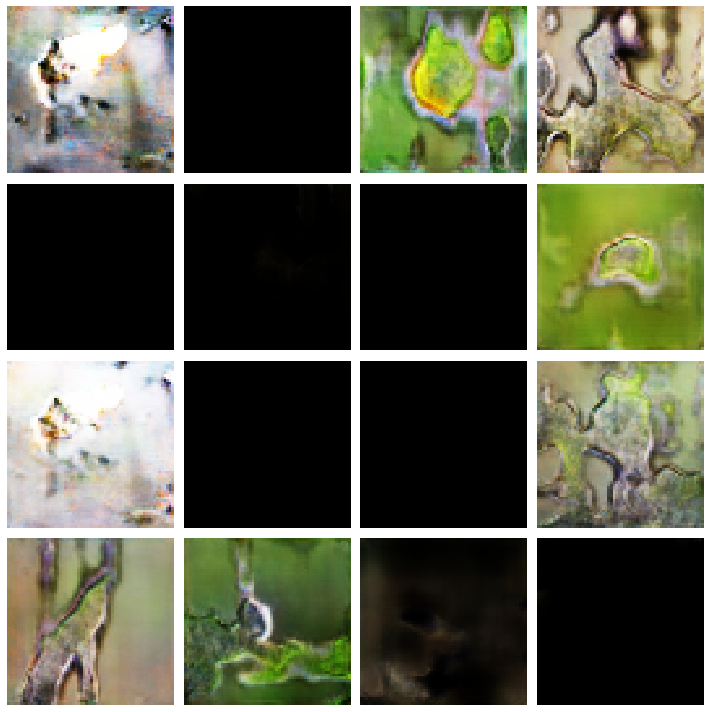

Time for epoch 645 is 19.22178840637207 sec
Time for epoch 646 is 18.724933862686157 sec
Time for epoch 647 is 18.58566427230835 sec
Time for epoch 648 is 18.623584032058716 sec
Time for epoch 649 is 18.596062421798706 sec
Time for epoch 650 is 18.563296794891357 sec
Time for epoch 651 is 18.620405673980713 sec
Time for epoch 652 is 18.60891819000244 sec
Time for epoch 653 is 18.56778621673584 sec
Time for epoch 654 is 18.569671154022217 sec
Time for epoch 655 is 18.598917245864868 sec
Time for epoch 656 is 18.54747772216797 sec
Time for epoch 657 is 18.596033096313477 sec
Time for epoch 658 is 18.564990520477295 sec
Time for epoch 659 is 18.58187699317932 sec


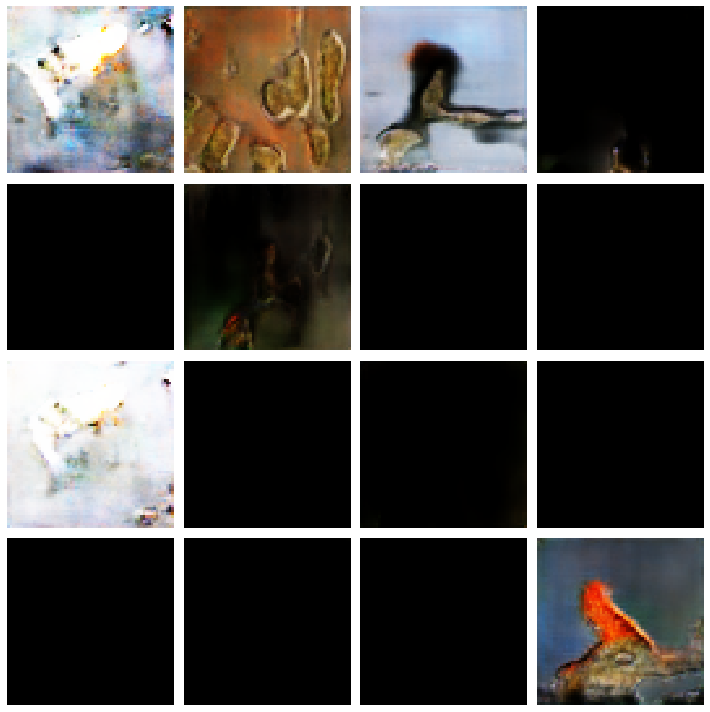

Time for epoch 660 is 19.242356777191162 sec
Time for epoch 661 is 18.581746339797974 sec
Time for epoch 662 is 18.5923593044281 sec


KeyboardInterrupt: ignored

In [0]:
train(dataset, generator, discriminator, g_optimizer, d_optimizer, seeds, epochs=NUM_EPOCHS)

In [0]:
generator.save('drive/My Drive/Colab Notebooks/pixir/generator_epoch_2660.h5')
discriminator.save('drive/My Drive/Colab Notebooks/pixir/discriminator_epoch_2660.h5')

In [0]:
g_optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 2e-05,
 'name': 'Adam'}

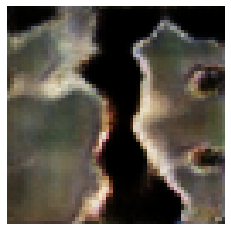

In [0]:
noises = tf.random.normal((16, 100))
inputs = tf.concat((noises, seeds), axis=-1)

preds = gen.predict(inputs)
import matplotlib.pyplot as plt
preds = (preds + 1) * 0.5
plt.imshow(preds[10])
plt.axis('off')
plt.show()

In [0]:
import glob
filenames = glob.glob('generated_image_epoch_*.png')
filenames = sorted(filenames, key=lambda x: (len(x), x))
filenames

['gan_generated_image_epoch_0.png',
 'gan_generated_image_epoch_9.png',
 'gan_generated_image_epoch_19.png',
 'gan_generated_image_epoch_29.png',
 'gan_generated_image_epoch_39.png',
 'gan_generated_image_epoch_49.png',
 'gan_generated_image_epoch_59.png',
 'gan_generated_image_epoch_69.png',
 'gan_generated_image_epoch_79.png',
 'gan_generated_image_epoch_89.png',
 'gan_generated_image_epoch_99.png',
 'gan_generated_image_epoch_109.png',
 'gan_generated_image_epoch_119.png',
 'gan_generated_image_epoch_129.png',
 'gan_generated_image_epoch_139.png',
 'gan_generated_image_epoch_149.png',
 'gan_generated_image_epoch_159.png',
 'gan_generated_image_epoch_169.png',
 'gan_generated_image_epoch_179.png',
 'gan_generated_image_epoch_189.png',
 'gan_generated_image_epoch_199.png',
 'gan_generated_image_epoch_209.png',
 'gan_generated_image_epoch_219.png',
 'gan_generated_image_epoch_229.png',
 'gan_generated_image_epoch_239.png',
 'gan_generated_image_epoch_249.png',
 'gan_generated_image_epo

In [0]:
import imageio
import glob
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('generated_image_epoch_*.png')
  filenames = sorted(filenames, key=lambda x: (len(x), x))
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
